### Dataset 3 - Small image dataset for unsupervised clustering

**Description:**
The "Small Image Dataset for Unsupervised Clustering" contains 80 images divided amoungst the following distribution: dogs (10), cats (10), family (20), alone (20), and food (20). Each image is unlabeled, requiring analysis based solely on its visual characteristics based on the premise of checking the possiblity to cluster all the photos in your phone automatically without labeling.

**Source:**
https://www.kaggle.com/datasets/heavensky/image-dataset-for-unsupervised-clustering


**Machine Learning Task:**
Clustering

**Motivation:**
While foundational datasets like MNIST, STL-10, CIFAR-10, and ImageNet are widely used, we specifically chose an image dataset tailored for unsupervised clustering. Distance metrics between image pixel such as the known Wasserstien distance (also known as Earth Mover’s Distance) could be interesting when used in analysis for machine learning to measure dissimilarity between two probability distributions, and this dataset meets our requirements for experimenting with clustering methods.

**Objective:**
Implement unsupervised learning techniques to group similar images based on visual features, facilitating tasks like image organization, pattern recognition, and anomaly detection.

---

The two machine learning models that will be used in this unsupervised learning clustering task are Agglomerative Hierarchial Clustering & K-Medoids.

---

*Note:* while the images in this dataset do have filenames for the proper class labels of each image, since we are treating this as a unsupervised task (as is mentioned in the Kaggle name) we will proceed as if the file names were ambiguous and didn't have the class label names.

In [2]:
# optional code cell when using Google Colab with Google Drive
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
%cd /content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1WQXS29TweBkqJf6hgSqcc7ZDIQ9jJ8rc/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class


In [3]:
#imports
import numpy as np
import pandas as pd

from scipy import stats as sps
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

from collections import defaultdict, Counter

import os
import math
import cv2
from PIL import Image

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.stats import wasserstein_distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

!pip install kmedoids
from kmedoids import KMedoids


!pip install kneed
from kneed import KneeLocator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 6.1 MB/s eta 0:00:00


# Brief Exploration of the Dataset

In this section, Exploratory Data Analysis (EDA) is performed on the dataset to gain insight into the image dimensionality, file types, context and generally common patterns in the data that will be handled and noted for pre-processing and future work

In [ ]:

image_folder = "/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class"


#get file formats
file_formats = Counter()
total_images = 0

for filename in os.listdir(image_folder):

    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        total_images += 1

        #extract all file extension
        ext = filename.split('.')[-1].lower()
        file_formats[ext] += 1

print(f"Total Number of Images: {total_images} \n")
print("File Format Distribution:")

for fmt, count in file_formats.items():
    print(f".{fmt.upper()}: {count} images")


Total Number of Images: 80 

File Format Distribution:
.JPG: 80 images


There are a total of **80** images in this dataset, all of which have consistent file formatting of **JPG**. This is a good start because maintaining consistent file formats is important. Inconsistent formats or unnecessary file conversions can sometimes lead to loss of quality (lossy conversion), which may affect analysis results.

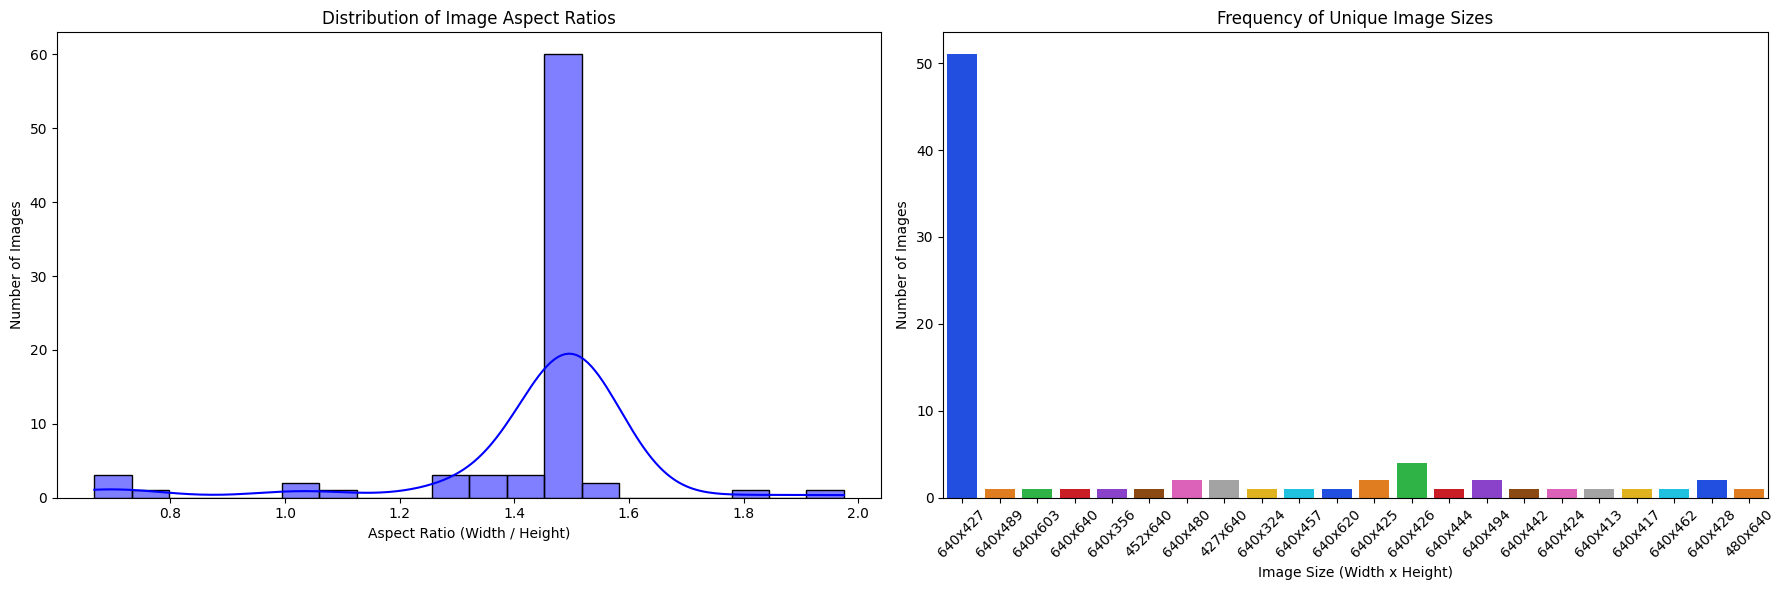

In [ ]:
aspect_ratios, image_sizes = list(), list()

#process images to extract aspect ratios and sizes
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(image_folder, filename)
        with Image.open(image_path) as img:
            aspect_ratio = img.width / img.height
            aspect_ratios.append(aspect_ratio)
            image_sizes.append((img.width, img.height))

#count unique image sizes
size_counts = Counter(image_sizes)

#create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(aspect_ratios, kde=True, bins=20, color="blue", ax=axes[0])
axes[0].set_title("Distribution of Image Aspect Ratios")
axes[0].set_xlabel("Aspect Ratio (Width / Height)")
axes[0].set_ylabel("Number of Images")

sizes, counts = zip(*size_counts.items())
sizes = [f"{w}x{h}" for w, h in sizes]
sns.barplot(x=sizes, y=counts, ax=axes[1], hue=sizes, legend=False, palette="bright")
axes[1].set_title("Frequency of Unique Image Sizes")
axes[1].set_xlabel("Image Size (Width x Height)")
axes[1].set_ylabel("Number of Images")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

The dataset contains images with a variety of sizes, as illustrated in the above plot. While the majority of images have a size of **640x427**, a significant number of other sizes are present, such as **640x489, 640x603, 640x640**, and many more. This inconsistency in image dimensions poses a challenge as we proceed with further analysis or modeling tasks. Clustering models, generally require a consistent input size, and variations in image dimensions can lead to issues during preprocessing, feature extraction, and clustering. To address this, we will need to resize or pad the images to a common dimension to ensure minimal loss of information.

In addition to varying image sizes, the aspect ratio distribution show more variability. The histogram of aspect ratios show that most images are close to **1.5**, showing more landscape orientation. However, there are also images with lower aspect ratios (e.g., close to 1.0) and some with higher values exceeding 1.7, representing square or wide-format orientations. This variability can lead to distortion or cropping when resizing images directly to a fixed size, which may result in loss of important visual features.

To ensure uniformity in the dataset and avoid these issues, preprocessing will play a crucial role. Images need to be resized to a consistent dimension, which will be **640x640** in out case. While padding images (e.g., with black borders) can help avoid distortion, it may have a negative effect on clustering, as the added black borders could introduce unwanted artifacts or noise that may interfere with the clustering process.

CMYK filetype: mandu-g79128b0db_640.jpg


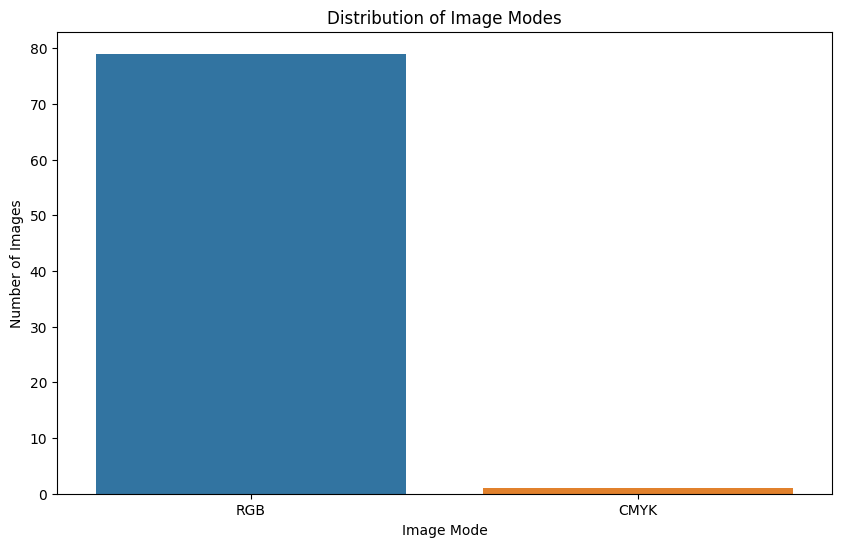

In [ ]:
image_modes = list()

#process each image and collect its mode
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(image_folder, filename)
        with Image.open(image_path) as img:
            image_modes.append(img.mode)  # ()"RGB", "L", "CMYK")
            if img.mode != "RGB":
                print(f"{img.mode} filetype: {filename}")

#counting the frequency of each mode
mode_counts = Counter(image_modes)

#converting mode counts to lists for plotting
modes, counts = zip(*mode_counts.items())

#plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=list(modes), y=list(counts), hue=list(modes), legend=False)
plt.title("Distribution of Image Modes")
plt.xlabel("Image Mode")
plt.ylabel("Number of Images")
plt.show()

As observed from the distribution of image modes, the majority of the images are in *RGB* format. However, there is one image file, *mandu-g79128b0db_640.jpg*, that is in the *CMYK* mode. While converting CMYK to RGB using libraries such as OpenCV or PIL is straightforward and will be performed due to the limited dataset size, it is generally advisable to filter out such variations in image modes. Differences in image modes can introduce inconsistencies during processing, as the underlying color spaces (RGB vs. CMYK) are fundamentally different. Keeping all images are in a consistent format is typically preferred for tasks like ours of clustering to avoid unintended discrepancies or errors. Generally, variations in our dataset are preferred to be ignored for tasks like clustering, as there is no ground truth available to guide or validate the clustering process.

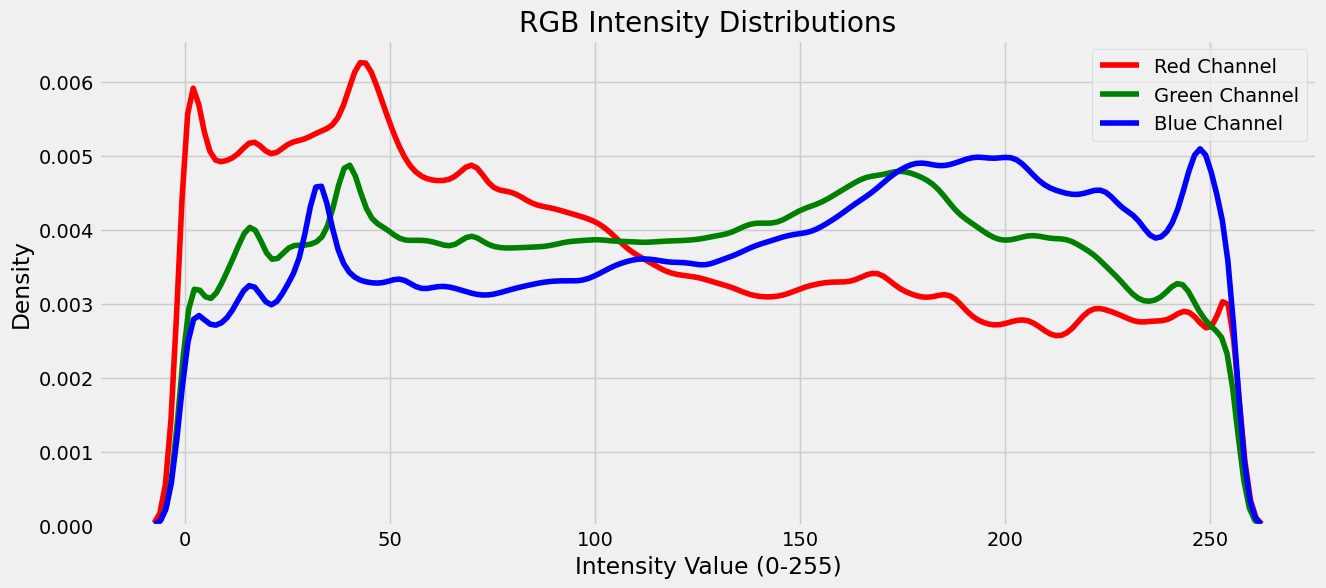

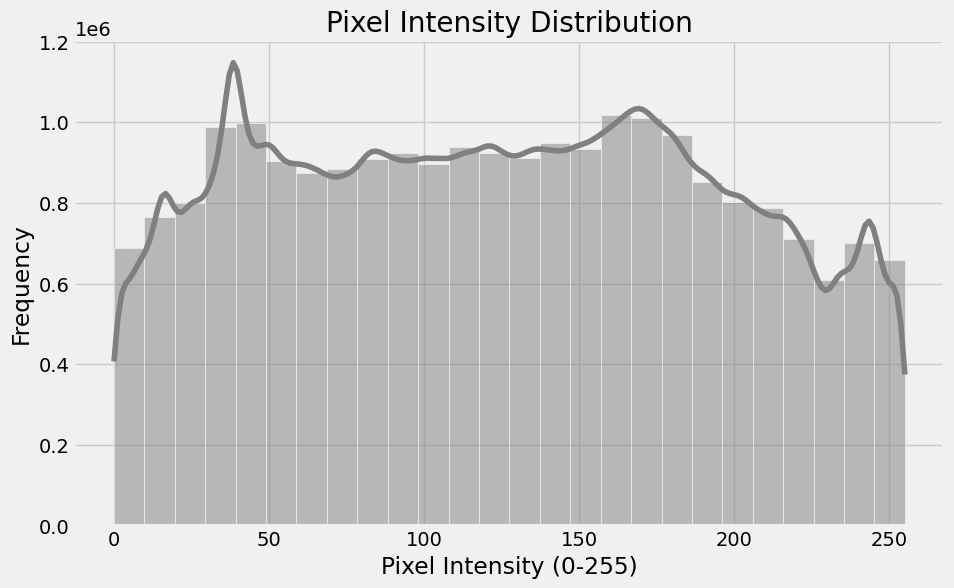

In [ ]:
# initialize all lists for RGB channels and pixel intensities
red_channel, green_channel, blue_channel, pixel_intensities  = list(), list(), list(), list()


#function to check if image is RGB
def is_rgb(image):
    return len(image.shape) == 3 and image.shape[2] == 3  # Height, Width, 3 Channel dimension

#process only the RGB images
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(image_folder, filename)

         #read in image
        img = cv2.imread(image_path)

        #checks for RGB format
        if img is not None and is_rgb(img):

            #split RGB channels
            red_channel.extend(img[:, :, 0].flatten())
            green_channel.extend(img[:, :, 1].flatten())
            blue_channel.extend(img[:, :, 2].flatten())

            #compute pixel intensities (mean across channels)
            pixel_intensities.extend(np.mean(img, axis=2).flatten())
        else:
            print(f"Skipping non-RGB image: {filename}")

#plotting
plt.figure(figsize=(14, 6))
sns.kdeplot(red_channel, color="red", label="Red Channel")
sns.kdeplot(green_channel, color="green", label="Green Channel")
sns.kdeplot(blue_channel, color="blue", label="Blue Channel")
plt.title("RGB Intensity Distributions")
plt.xlabel("Intensity Value (0-255)")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(pixel_intensities, bins="sturges", kde=True, color="gray")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.show()


The first plot here shows the overall pixel intensity distribution across all images. The intensities range from 0 to 255, with a noticeable peak around lower intensity values (~50), indicating the presence of darker pixels. The mid-range intensities (100–200) are relatively evenly distributed, while higher intensities (>200) gradually decrease. This suggests varying brightness levels and contrast across the dataset.

The second plot shows the intensity distributions for the RGB channels. The Red channel has a strong concentration of lower intensity values, indicating more dark red tones in the images. The Green and Blue channels are more evenly spread across the mid-to-high intensity range, with the Blue channel showing higher intensity peaks compared to the other two. This indicates that brighter regions in the dataset are primarily influenced by blue and green tones, while darker regions are more dominant in the red channel. These variations in intensity and channel distributions will be considered during feature extraction later when deciding what tool to use for dimensionality reduction of these images while keeping the intensities of these pixels to ensure consistency across images for downstream tasks.

In [ ]:
red_means, green_means, blue_means = list(), list(), list()

'''
utilizing this function :

def is_rgb(image):
    return len(image.shape) == 3 and image.shape[2] == 3  # Height, Width, 3 Channels

from prior code block
'''

#[rocess only RGB images
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path)
        if img is not None and is_rgb(img):


            #compute mean for each channel
            red_means.append(np.mean(img[:, :, 0]))
            green_means.append(np.mean(img[:, :, 1]))
            blue_means.append(np.mean(img[:, :, 2]))
        else:
            print(f"Skipping non-RGB image: {filename}")

#calculate overall mean and standard deviation for each channel
if red_means and green_means and blue_means:
    overall_red_mean = np.mean(red_means)
    overall_green_mean = np.mean(green_means)
    overall_blue_mean = np.mean(blue_means)

    overall_red_std = np.std(red_means)
    overall_green_std = np.std(green_means)
    overall_blue_std = np.std(blue_means)

    print("Overall RGB Channel Statistics:")
    print("===============================\n")

    print(f"Red Channel: Mean = {overall_red_mean:.2f}, Std = {overall_red_std:.2f}")
    print(f"Green Channel: Mean = {overall_green_mean:.2f}, Std = {overall_green_std:.2f}")
    print(f"Blue Channel: Mean = {overall_blue_mean:.2f}, Std = {overall_blue_std:.2f}")
else:
    print("No valid RGB images found for processing.")

Overall RGB Channel Statistics:

Red Channel: Mean = 108.72, Std = 36.33
Green Channel: Mean = 125.99, Std = 33.60
Blue Channel: Mean = 137.65, Std = 35.69


The overall RGB channel statistics indicate that the *Red channel* has a *mean of 108.72* and a *standard deviation of 36.33*, the *Green channel* has a *mean of 125.99* and a *standard deviation of 33.60*, and the *Blue channel* has a *mean of 137.65* with a *standard deviation of 35.69*. These values show that the Blue and Green channels tend to have higher mean intensities compared to the Red channel, suggesting that the dataset is biased toward cooler tones.

To address these variations, we will be applying *per-image standardization* instead of global normalization or standardization. By centering each image’s pixel values around its own mean and scaling by its standard deviation, this method ensures that each image contributes equally to downstream tasks like clustering, regardless of differences in overall brightness or channel intensity biases. Rescaling the standardized images back to the 0–255 range preserves compatibility with image storage and visualization.

For clustering tasks, this approach could help mitigate the effects of intensity variations across images, improving the consistency of features extracted. However, standardizing at the individual image level may reduce global color differences, which could impact clustering if color is a key differentiating factor. This will come down to the effectivness of our feature extraction process with dimensionality reduction which will be seen later.

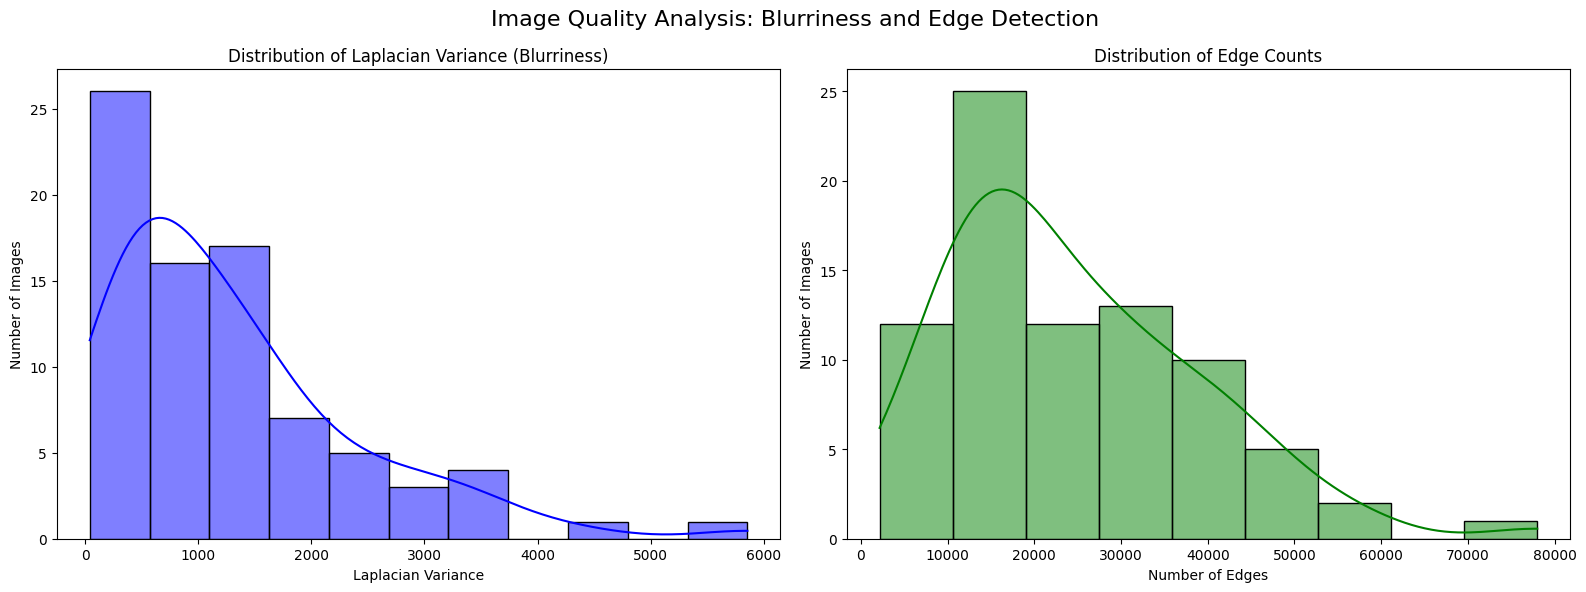

In [ ]:
laplacian_variances, edge_counts, file_names = list(), list(), list()

#function to compute Laplacian variance (blurriness)
def compute_laplacian_variance(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Error reading image at {image_path}")
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    variance = laplacian.var()
    return variance

#function to compute edge count using Canny edge detection
def compute_edge_count(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Error reading image at {image_path}")
    edges = cv2.Canny(image, threshold1=100, threshold2=200) #normal thresholds most people do
    edge_count = np.sum(edges > 0)
    return edge_count

#process images
def analyze_images(image_folder):
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(image_folder, filename)
            try:
                laplacian_score = compute_laplacian_variance(image_path)
                edge_count = compute_edge_count(image_path)
                laplacian_variances.append(laplacian_score)
                edge_counts.append(edge_count)
                file_names.append(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

#plotting
def plot_results():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Image Quality Analysis: Blurriness and Edge Detection", fontsize=16)

    sns.histplot(laplacian_variances, kde=True, color="blue", ax=axes[0])
    axes[0].set_title("Distribution of Laplacian Variance (Blurriness)")
    axes[0].set_xlabel("Laplacian Variance")
    axes[0].set_ylabel("Number of Images")

    sns.histplot(edge_counts, kde=True, color="green", ax=axes[1])
    axes[1].set_title("Distribution of Edge Counts")
    axes[1].set_xlabel("Number of Edges")
    axes[1].set_ylabel("Number of Images")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


analyze_images(image_folder)
plot_results()


The left plot shows the *Laplacian variance distribution, which is a measure of image sharpness. A significant number of images have low Laplacian variance, indicating they are potentially blurry. Most images fall below a variance value of 1000, with a sharp decline beyond this point. The right plot displays the *edge count distribution*, where the majority of images have edge counts between 10,000 and 40,000. A smaller set of images has significantly higher edge counts, suggesting a few images have strong edge features or higher structural complexity.

Blurry images with low Laplacian variance may lack meaningful texture or edge features, which could negatively impact clustering by reducing the distinctiveness of image features. Images with higher edge counts may dominate the clustering process due to their richer feature set, leading to imbalanced clusters.

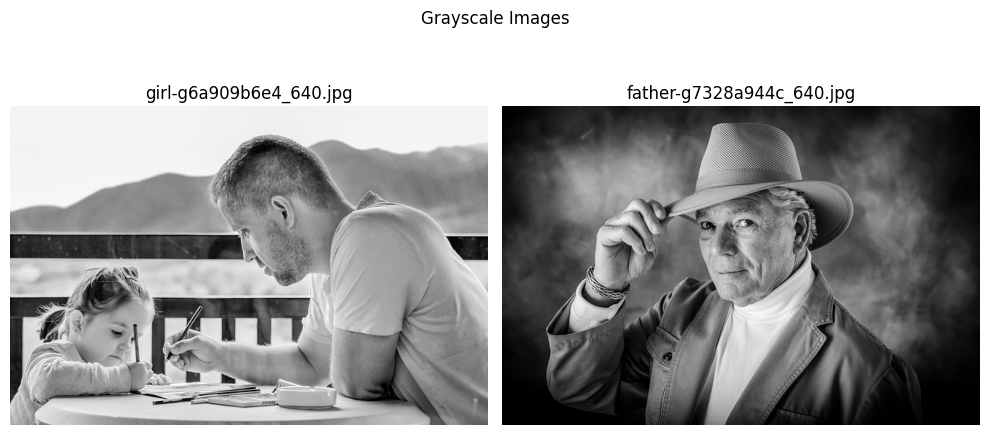

In [77]:
def check_grayscale_pil(image_path):
    img = Image.open(image_path).convert("RGB")
    for pixel in img.getdata():
        r, g, b = pixel
        if r != g or g != b:  #if RGB channels must be equal for grayscale images
            return False
    return True

grayscale_images = list()

for image_file in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_file)
    if check_grayscale_pil(image_path):
        grayscale_images.append(image_path)

#plot the grayscale images in subplots
if len(grayscale_images) > 0:
    fig, axes = plt.subplots(1, len(grayscale_images), figsize=(10, 5))
    fig.suptitle("Grayscale Images")

    if len(grayscale_images) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, grayscale_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path))

    plt.tight_layout()
    plt.show()
else:
    print("No grayscale images found.")

In this dataset, while most of the images are in RGB format (with the exception of one CMYK image), as seen from the above test, there exist RGB images where the red, green, and blue channels have identical values, making them really **grayscale**. These images are still left in the RGB format but should conceptually be treated as grayscale.

An interesting observation here is to think about how our clustering algorithms should later on handle these grayscale images. Since both images share identical luminance values (foreshadowing for the feature extraction section 😃), it is feasible to hypothesize that the algorithms will group these two images into the same cluster.

In the later sections where we fit our two clustering algorithms of choice to our data, it will be seen if this hypothesis comes to be true or whether the clustering models will fail to account for their shared luminance. If the algorithms fail to cluster these images together, it could show the limitations of our models due to the small dataset size or the clustering methods themselves. Nevertheless, clustering these images correctly based on luminance intensities would align with bare expectations for a decent feature extraction process and clustering model.


In [32]:

#function to compute SSIM between two images
def compute_ssim(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)  #convert to grayscale or this won't work
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    return ssim(gray1, gray2)

#function computes cosine similarity between two flattened grayscale images
def compute_cosine_similarity(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)  #convert to grayscale or this won't work
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    return cosine_similarity(gray1.flatten().reshape(1, -1), gray2.flatten().reshape(1, -1))[0][0]

#potential duplicate detection from preprocessed dataset
output_folder = "/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class_pre_processed"
image_files = [f for f in os.listdir(output_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
images, filenames = list(), list()

#load images from preprocessed dataset
for file in image_files:
    img = cv2.imread(os.path.join(output_folder, file))
    if img is not None:
        images.append(img)
        filenames.append(file)


n = len(images)
duplicates = list()

for i in range(n):
    for j in range(i + 1, n):
        #compute SSIM
        ssim_value = compute_ssim(images[i], images[j])
        #compute Cosine Similarity
        cosine_value = compute_cosine_similarity(images[i], images[j])

        if ssim_value > 0.9 or cosine_value > 0.95:  #arbritary threshold for similarity
            duplicates.append((filenames[i], filenames[j], ssim_value, cosine_value))

print("Potential Duplicate Images (SSIM > 0.9 or Cosine Similarity > 0.95):")
for dup in duplicates:
    print(f"Image Pair: {dup[0]} - {dup[1]} | SSIM: {dup[2]:.4f}, Cosine Similarity: {dup[3]:.4f}")


Potential Duplicate Images (SSIM > 0.9 or Cosine Similarity > 0.95):
Image Pair: fried-rice-g8b4a54246_640_processed.jpg - sad-g7e6ada8a4_640_processed.jpg | SSIM: 0.5260, Cosine Similarity: 0.9615
Image Pair: cat-gf324dae69_640_processed.jpg - sad-g7e6ada8a4_640_processed.jpg | SSIM: 0.7110, Cosine Similarity: 0.9569
Image Pair: sad-g7e6ada8a4_640_processed.jpg - mother-gea63914a7_640_processed.jpg | SSIM: 0.5135, Cosine Similarity: 0.9631
Image Pair: sad-g7e6ada8a4_640_processed.jpg - puppy-g0235e261e_640_processed.jpg | SSIM: 0.3476, Cosine Similarity: 0.9511
Image Pair: sad-g7e6ada8a4_640_processed.jpg - pizza-gbc9c3ad3c_640_processed.jpg | SSIM: 0.3758, Cosine Similarity: 0.9550


For this analysis of image similarity from the **preprocessed dataset**, is based on metrics of SSIM (Structural Similarity Index) and Cosine Similarity,which reveal some image pairs with high similarity scores (Cosine Similarity > 0.95). These findings again were obtained after **preprocessing steps**, specifically after resizing all images to the same dimensions (640x640), to allow for the similarity metrics to be computed reliably on images of identical size. This step was important as similarity calculations require consistent input dimensions.

During similarity computation, images are typically converted to grayscale, as SSIM and Cosine Similarity operate on intensity values. However, in our preprocessing workflow, you will see next that grayscale conversion will not be performed to preserve the color information contained in the RGB channels, as this approach will be done in hope to maintain these color features for clustering.

The presence of potential duplicate images can affect clustering performance by introducing redundant or near-identical data points. These images could skew cluster formation by causing multiple images with high similarity to dominate specific clusters, leading to imbalanced clusters which reduces overall clustering performance. Additionally, duplicates could mask underlying patterns within the dataset, decreasing the clustering algorithm's ability to correctly identify diverse groups. Of course for such a small dataset as we have, there isn't much we can do with similar image pixel data as we need all the data samples we have. There isn't any explicit duplicate data but near identical images do pose a potential concern.

# Pre-processing for the Dataset


In this section, the dataset is preprocessed, which will be guided by the previous section of exploration of the dataset as well as for later feature engineering/extraction plans for the dataset.

In [30]:
input_folder = image_folder
output_folder = "/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class_pre_processed"
TARGET_SIZE = (640, 640)

#build preprocessed output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

def resize_force_square(image_path, target_size):

    image = Image.open(image_path)
    return image.resize(target_size, Image.Resampling.LANCZOS) #uses LANCZOS resampling algorithm for resizing into square 640x640

#resize all images from input folder and save to output folder
file_list = os.listdir(input_folder)
for file_name in file_list:
    input_path = os.path.join(input_folder, file_name)

    #append '_processed' to filename
    base_name, ext = os.path.splitext(file_name)
    output_file_name = f"{base_name}_processed{ext}"
    output_path = os.path.join(output_folder, output_file_name)

    try:
        resized_image = resize_force_square(input_path, TARGET_SIZE)

        #save all the resized image to the output folder
        resized_image.save(output_path)
    except Exception as e:
        print(f"Failed to process {input_path}: {e}")

print("All images have been resized and saved to the output folder with '_processed' suffix.")


All images have been resized and saved to the output folder with '_processed' suffix.


As mentioned before in our Exploratory Data Analysis section, we are resizing all the images into **640x640**. We are doing this using the **LANCZOS resampling algorithm**, which is based on a mathematical sinc function. The LANCZOS algorithm is widely regarded as one of the highest-quality resampling methods, as it minimizes aliasing and preserves image detail by taking into account the contributions of surrounding pixels when computing the intensity of a target pixel.

This algorithm works by interpolating pixel values in a way that considers a weighted average of nearby pixels. The sinc function, which is the basis of this method, allows for better retention of image pixel details, specifically in regions with sharp edges or fine textures. This makes LANCZOS resampling an ideal choice for resizing images without introducing artifacts or losing  information.

Using this method allows us to fix the images into the **640x640** size while maintaining as much of the original image quality as possible. However, while this resizing step ensures uniformity across the dataset, it may introduce **scale shifting invariants**, essentially where the relative scales of objects within the image are altered. This makes sense as when resizing images that have aspect ratios closer to landscape orientation, it will cause squshing or distortion in the images as they are fit into the **640x640** pixel grid box. This issue brought up here, will be addressed further in the **feature engineering/extraction** portion, where techniques will be implemented to acquire features that are resilient to these changes.

In [75]:


def per_image_standardization(image_array):

    #compute mean and standard deviation for the image
    mean = np.mean(image_array)
    std = np.std(image_array)

    #handle specific edge case of std being zero
    if std == 0:
        std = 1e-10  #very small constant to avoid division by zero

    #standardize the image
    return (image_array - mean) / std

def process_images(input_folder, output_folder):

    #simple check if output folder there
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, file_name)
        output_path = os.path.join(output_folder, file_name)

        try:

            image = Image.open(input_path)

            if image.mode == "CMYK":
                print(f"Converting CMYK to RGB: {file_name}")
                image = image.convert("RGB")


            image_array = np.array(image, dtype=np.float32)

            #standardize the image
            standardized_image = per_image_standardization(image_array)

            #eescale standardized image back to valid range (0-255) for saving and visualization reasons later
            standardized_image = (standardized_image - standardized_image.min()) / (standardized_image.max() - standardized_image.min()) * 255
            standardized_image = standardized_image.astype(np.uint8)

            #save the standardized image
            Image.fromarray(standardized_image).save(output_path)
        except Exception as e:
            print(f"Failed to process {input_path}: {e}")

process_images(output_folder, output_folder)
print("Finished Processing and Standardizing all images.")


Finished Processing and Standardizing all images.


As mentioned in the Exploratory Data Analysis section, we are performing **per-image standardization** as part of our preprocessing pipeline. This involves normalizing each image individually by subtracting its mean pixel value and dividing by its standard deviation. This process ensures that each image's pixel values are centered around zero and scaled relative to its own distribution. Unlike global standardization, which standardizes across the entire dataset, this approach retains the **local color and intensity features** specific to each image, which is critical for maintaining the unique characteristics that may influence clustering.

This code keeps consistent **image mode formatting** across the dataset. In our case, there is the *1 CMYK imag* in the dataset, which is converted to RGB to maintain uniformity. As mentioned before, consistent image modes are important to prevent discrepancies during later feature extraction and analysis, as variations in color channels could affect clustering downstream tasks.

The standardization process is further appraoched by rescaling the standardized images back to the 0–255 range after processing. This allows the images to remain compatible with visualization later for our clustering model evaluation while preserving the benefits of *per-image standardization*.

*Note:* We did resizing first before per-image standardization since resizing changes the dimensions of the images, and performing standardization beforehand would result in inconsistent scaling. By resizing first, we keep all images the same shape and size, making the standardization process consistent and meaningful across the dataset.

# Feature Extraction/Feature Learning from the Dataset

In this section, now that we have done dataset preprocessing, we will now look to approach feature extraction from our image dataset before heading towards our clustering models.

We will use **Opponent SIFT** for feature extraction to extract **1-dimensional histograms of gradients** from the images in terms of luminance from the RGB images. We will also be computing the **pair-wise distance matrix** using **Wasserstein distance** (also called Earth Mover’s distance).


Feature extraction complete. Opponent SIFT histograms saved as 'opponent_sift_histograms.npy'.


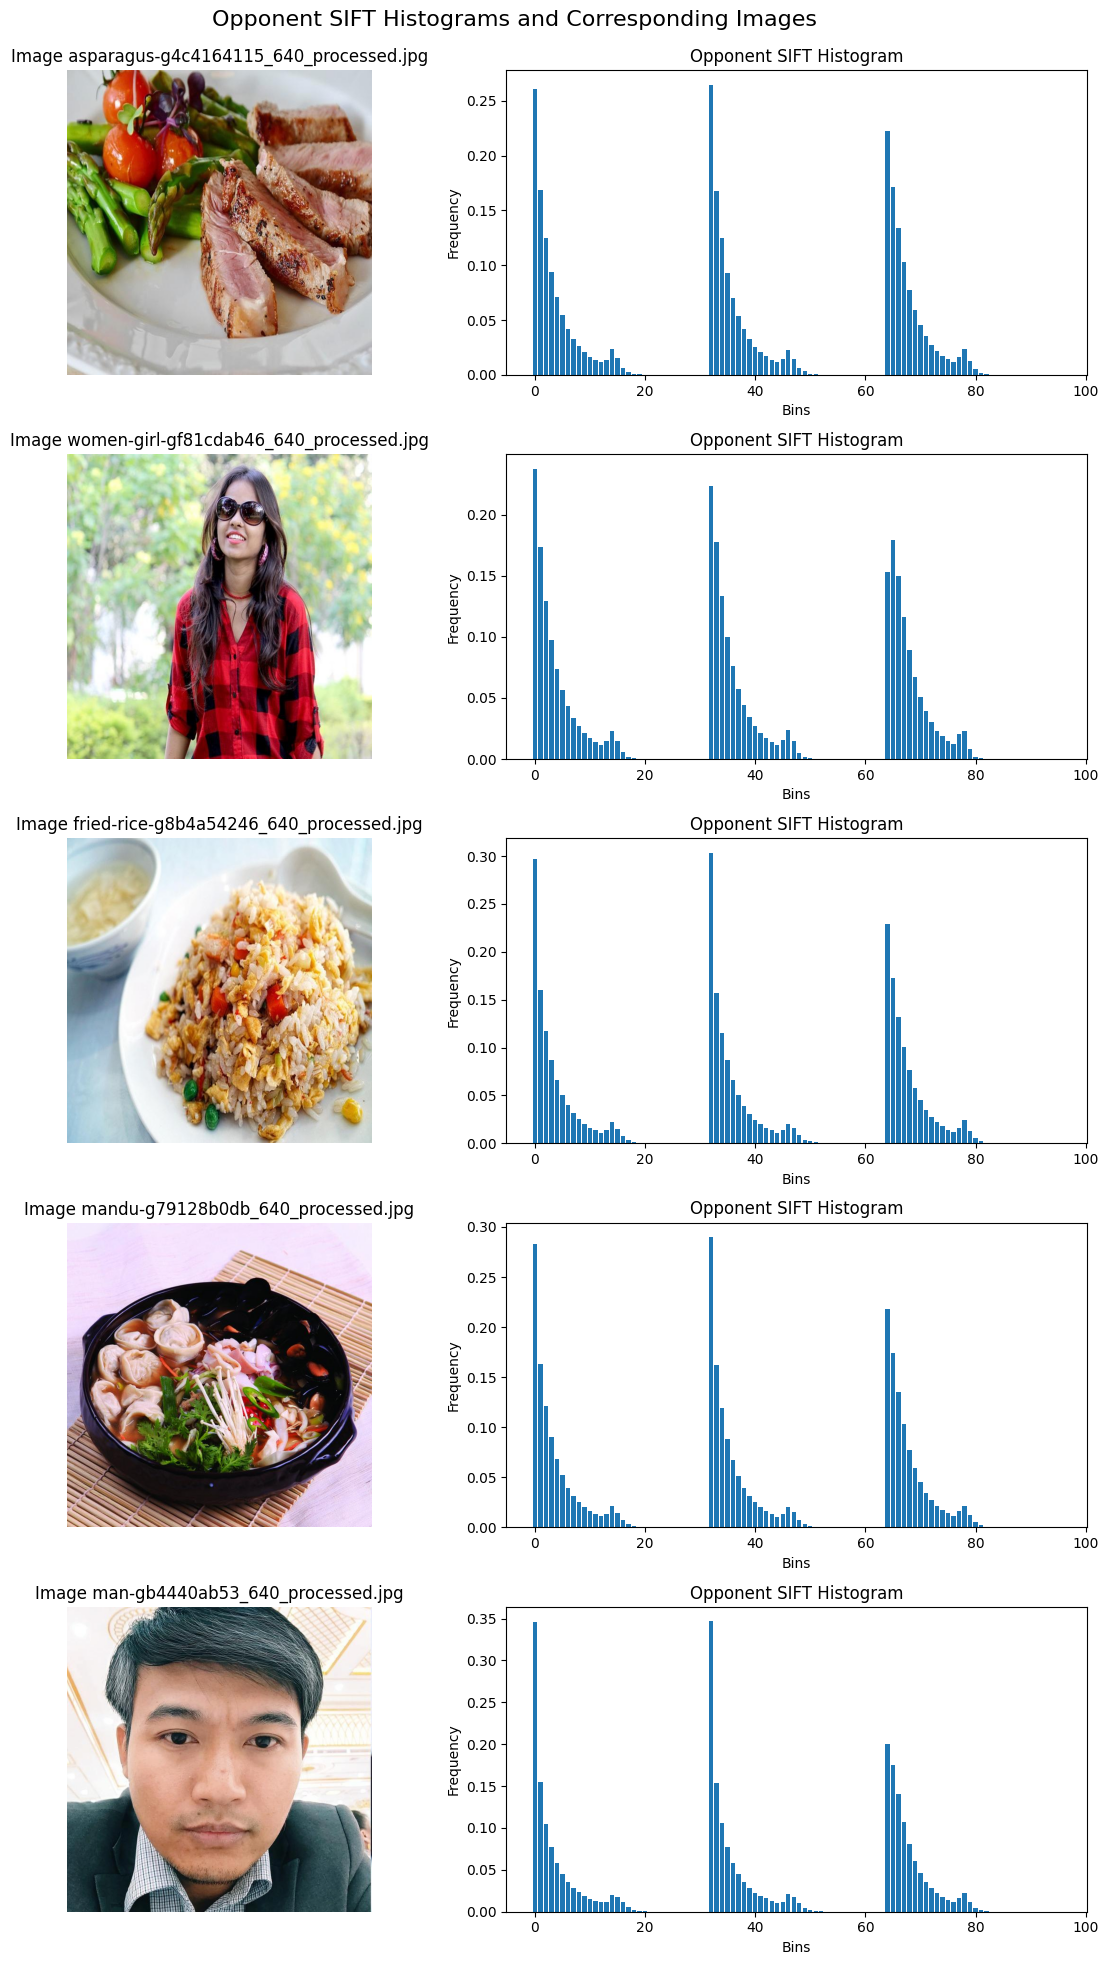

In [33]:

#instantiate SIFT extractor
sift = cv2.SIFT_create()

def extract_opponent_sift_histogram(image_path, bins=32):

    #read in the image from opencv for faster run of code
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")


    #compute Opponent color channels
    O1 = (image[:, :, 2] - image[:, :, 1]) / np.sqrt(2)
    O2 = (image[:, :, 2] + image[:, :, 1] - 2 * image[:, :, 0]) / np.sqrt(6)
    O3 = (image[:, :, 2] + image[:, :, 1] + image[:, :, 0]) / np.sqrt(3)  # luminance

    opponent_channels = [O1, O2, O3]
    combined_hist = []

    for channel in opponent_channels:  #each Opponent channel
        channel = (channel * 255).astype(np.uint8)  #convert to 8-bit for SIFT
        keypoints, descriptors = sift.detectAndCompute(channel, None)

        if descriptors is None:
            hist = np.zeros(bins)  #empty histogram

        else:

            #flatten descriptors and create a histogram
            hist, _ = np.histogram(descriptors.flatten(), bins=bins, range=(0, 256))

        #normalize the histogram
        hist = hist.astype(float) / np.sum(hist) if np.sum(hist) > 0 else hist
        combined_hist.append(hist)

    return np.concatenate(combined_hist)

opponent_sift_histograms, image_names = list(), list()
output_folder = "/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class_pre_processed"

for filename in os.listdir(output_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(output_folder, filename)

        try:
            histogram = extract_opponent_sift_histogram(image_path)
            opponent_sift_histograms.append(histogram)
            image_names.append(image_path)

        except Exception as e:
            print(f"Error processing image {filename}: {e}")

#Convert histograms to a np.ndarray
opponent_sift_histograms = np.array(opponent_sift_histograms)

#save the histograms for future clustering
np.save("/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/opponent_sift_histograms.npy", opponent_sift_histograms)
print("Feature extraction complete. Opponent SIFT histograms saved as 'opponent_sift_histograms.npy'.")

#plotting 5 images and their corresponding Opponent SIFT histograms
num_plots = min(5, len(image_names))

fig, axes = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots))
fig.suptitle("Opponent SIFT Histograms and Corresponding Images", fontsize=16)

for i in range(num_plots):

    img = cv2.cvtColor(cv2.imread(image_names[i]), cv2.COLOR_BGR2RGB)
    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Image {os.path.basename(image_names[i])}")

    axes[i, 1].bar(range(len(opponent_sift_histograms[i])), opponent_sift_histograms[i])
    axes[i, 1].set_title("Opponent SIFT Histogram")
    axes[i, 1].set_xlabel("Bins")
    axes[i, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


As seen above in the code cell, **Opponent SIFT** descriptors are extracted to generate 1-dimensional histograms that capture local image gradients from the luminance and opponent color channels (opposite color pairings). The script processes all images by splitting them into three opponent channels derived from the RGB image space. These channels include luminance (O3) and two opponent color spaces (O1 and O2). For each channel, SIFT keypoints and descriptors are computed, and the descriptors are flattened to form histograms. The histograms are normalized and concatenated to represent each image as a single feature vector. These feature vectors are then saved for further clustering.

---

#### Conceptual Overview of Opponent SIFT

Opponent SIFT operates by transforming the RGB image space into three opponent color channels:
- **O1**: $ \frac{R - G}{\sqrt{2}} $ - This represents the difference between the red and green channels.
- **O2**: $ \frac{R + G - 2B}{\sqrt{6}} $ - This accounts for the combined red-green contrast relative to blue.
- **O3**: $ \frac{R + G + B}{\sqrt{3}} $ - This is the luminance channel, capturing the intensity of the image.


This approach ensures that both color information (O1, O2) and luminance (O3) are incorporated into feature extraction. By transforming the image into these channels, Opponent SIFT emphasizes meaningful gradient differences across luminance and color, which are critical for analyzing both colored and black-and-white images.

---

#### Reason for Opponent SIFT

Opponent SIFT is chosen over other feature extraction or dimensionality reduction techniques for the following reasons:

1. **Comparison to Color SIFT**: While Color SIFT operates in RGB or HSV spaces, it fails to emphasize luminance effectively. Opponent SIFT captures luminance (O3), which is particularly important for datasets containing grayscale or black-and-white images. This inclusion ensures no loss of information for such images.

2. **Comparison to HOG**: HOG computes global gradient histograms but lacks robustness to scale variations. Opponent SIFT captures **local gradients** and is inherently **scale-invariant**, which is beneficial for the images we distorted or squished during resizing of the preprocessing section.

3. **Comparison to Dimensionality Reduction Techniques (PCA, ISOMAP, T-SNE)**: These methods focus on reducing data dimensionality by transforming or projecting features. However, for image data, gradient histograms extracted through SIFT hold greater importance in capturing spatial and structural patterns. Dimensionality reduction techniques may lose this essential information.

---

#### Observations from Opponent SIFT Histograms

The histograms extracted for the displayed images show distinct peaks and distributions across the bins. These peaks indicate the presence of dominant gradient magnitudes in localized regions of the images. Notably:
- Images with uniform backgrounds or smooth textures (e.g., "mandu-g79128b0db_640_processed.jpg") exhibit sharper, concentrated peaks, reflecting fewer keypoint descriptors.
- Images with complex textures or multiple objects (e.g., "fried-rice-g8b4a54246_640_processed.jpg") show broader distributions, indicating more keypoints and gradients across different regions.

---

#### Potential Effects on Clustering

The extracted histograms, being concise representations of local gradients, will serve as effective input features for clustering. Differences in histogram shapes and distributions will help differentiate images based on their texture, structure, and luminance. However, images with similar gradient distributions may pose challenges for clustering, as they could be grouped into the same cluster despite differences in semantics. The inclusion of luminance ensures better performance for grayscale images, mitigating potential loss of information.




In [4]:

sift_histograms_path = "/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/opponent_sift_histograms.npy"
sift_histograms = np.load(sift_histograms_path)

#function to compute pair-wise distance matrix using Wasserstein distance
def compute_distance_matrix(histograms):
    n = len(histograms)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i, j] = wasserstein_distance(histograms[i], histograms[j])
    return distance_matrix

distance_matrix = compute_distance_matrix(sift_histograms)

display(distance_matrix)

array([[0.        , 0.00287369, 0.00189514, ..., 0.00328685, 0.00550447,
        0.00176236],
       [0.00287369, 0.        , 0.0044751 , ..., 0.00395886, 0.00803625,
        0.00141196],
       [0.00189514, 0.0044751 , 0.        , ..., 0.002056  , 0.00368028,
        0.0033321 ],
       ...,
       [0.00328685, 0.00395886, 0.002056  , ..., 0.        , 0.0041858 ,
        0.00275422],
       [0.00550447, 0.00803625, 0.00368028, ..., 0.0041858 , 0.        ,
        0.00678014],
       [0.00176236, 0.00141196, 0.0033321 , ..., 0.00275422, 0.00678014,
        0.        ]])


The code above calculates a pairwise distance matrix for the **Opponent SIFT histograms** using the **Wasserstein distance**. The histograms, which represent 1-dimensional gradient distributions for each image, are compared pairwise to compute the "distance" or dissimilarity between each pair of images. This matrix will serve as input for clustering algorithms such as hierarchical clustering (Agglomerative) or K-medoids, which rely on pairwise distances to group similar data points effectively.

The **Wasserstein distance**, also known as the Earth Mover's Distance (EMD), measures the effort required to transform one histogram (distribution of mass) into another. It does this by considering not only the differences in histogram bin values but also the "cost" of shifting mass between bins. This property makes it particularly suited for comparing gradient histograms, where small shifts in bin positions due to variations in keypoint detection or image transformations (e.g., resizing) are common.

The following is the formal definition of the distance formula:

$$
W_p(\mu, \nu) = \left( \inf_{\gamma \in \Pi(\mu, \nu)} \int_{M \times M} d(x, y)^p \, d\gamma(x, y) \right)^{1/p}
$$

where:
- $ W_p(\mu, \nu) $ is the Wasserstein distance of order $ p $,
- $ \Pi(\mu, \nu) $ represents the set of all joint distributions (transport plans) whose marginals are $ \mu $ and $ \nu $,
- $ d(x, y) $ is the distance function between points $ x $ and $ y $,
- $ p \geq 1 $ determines the order of the distance.

For the **special case \( p = 1 \)** (also called the **Earth Mover's Distance**), the formula simplifies to:

$$
W_1(p, q) = \inf_{\gamma \in \Pi(p, q)} \int |x - y| \, d\gamma(x, y),
$$

where $ \Pi(p, q) $ represents the set of all joint distributions whose marginals are $ p $ and $ q $. Here, $ |x - y| $ denotes the absolute distance between $ x $ and $ y $.


Compared to Euclidean or Minkowski distances, the Wasserstein distance is more robust for histogram comparison because it accounts for the relative positions of bins. Euclidean distance measures only pointwise differences, ignoring the structure and shifts in the distributions, which can result in inaccurate distance calculations for histograms. On the other hand, Wasserstein distance preserves the overall relationship and smooth variations between histogram bins, leading to a more meaningful similarity measure.

Using the Wasserstein distance will help the clustering algorithms captures the similarity between images based on their gradient histograms (luminance captured from Opponent SIFT). By handling small shifts in gradient bins effectively, this approach reduces the risk of over-penalizing slight variations that do not affect image similarity. This is important after preprocessing steps such as resizing, which can introduce scale changes and keypoint localization shifts. The resulting pairwise distance matrix will enhance the performance of clustering algorithms, enabling more accurate grouping of images with similar local gradient patterns. Overall, this step plays a critical role in preparing the data for unsupervised clustering.


### Processing of the Dataset Using Two Different Machine Learning Methods

In this section, we proceed to apply our two differ unsupervised machine learning techniques in regards to clustering. The clustering methods we have chosen are **Agglomerative Hierarchical Clustering** and **K-Medoids** algorithms. Both methods will utilize the **pair-wise distance matrix** computed using the **Wasserstein distance** on the Opponent SIFT gradient histograms from the previous *Feature Extraction/Feature Learning* section, potentially allowing the clustering algorithms to cluster appropriate to meaningful features.


In [6]:

#range of k values to test
k_values = range(2, 11)

optimal_k_val = (4,5)

#storage for Cluster Distances (Sum of Wasserstein Distances), Silhouette Scores, and Labels
results = {
    "agglomerative": {"cluster_distance": list(), "silhouette": list(), "labels": dict()},
    "kmedoids": {"cluster_distance": list(), "silhouette": list(), "labels": dict()}
}

labels_agg_main, labels_k_medoids_main = list(), list()

#function to calculate cluster distance excluding diagonals
def calculate_cluster_distance(distance_matrix, labels):
    total_distance = 0
    for cluster_label in np.unique(labels):

        cluster_indices = np.where(labels == cluster_label)[0]

        intra_cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]

        cluster_sum = np.sum(intra_cluster_distances) - np.sum(np.diag(intra_cluster_distances))
        total_distance += cluster_sum / 2
    return total_distance

#agglomerative clustering
print("Running Agglomerative Clustering...")
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="complete")
    labels_agg = model.fit_predict(distance_matrix)

    if k == optimal_k_val[0]:
        labels_agg_main = labels_agg

    #cluster distance calculation (excluding self-distances)
    cluster_distance = calculate_cluster_distance(distance_matrix, labels_agg)
    results["agglomerative"]["cluster_distance"].append(cluster_distance)


    if len(np.unique(labels_agg)) > 1:
        silhouette_avg = silhouette_score(distance_matrix, labels_agg, metric="precomputed")
    else:
        silhouette_avg = 0
    results["agglomerative"]["silhouette"].append(silhouette_avg)


    results["agglomerative"]["labels"][k] = labels_agg

#k-medoids clustering
print("\nRunning K-Medoids Clustering...")
for k in k_values:
    model = KMedoids(n_clusters=k, method = 'pam', metric="precomputed")
    labels_k_medoids = model.fit_predict(distance_matrix)

    if k == optimal_k_val[1]:
        labels_k_medoids_main = labels_k_medoids

    #cluster distance calculation (excluding self-distances)
    cluster_distance = calculate_cluster_distance(distance_matrix, labels_k_medoids)
    results["kmedoids"]["cluster_distance"].append(cluster_distance)

    #silhouette Score
    if len(np.unique(labels_k_medoids)) > 1:
        silhouette_avg = silhouette_score(distance_matrix, labels_k_medoids, metric="precomputed")

    else:
        silhouette_avg = 0

    results["kmedoids"]["silhouette"].append(silhouette_avg)


    results["kmedoids"]["labels"][k] = labels_k_medoids

Running Agglomerative Clustering...

Running K-Medoids Clustering...


### Clustering Methods: Agglomerative Hierarchical Clustering and K-Medoids

#### Agglomerative Hierarchical Clustering  
Agglomerative Hierarchical Clustering is a bottom-up clustering method where each data point starts as its own cluster. Pairs of clusters are iteratively merged based on a distance metric until the desired number of clusters, $ k $, is reached. The process can be mathematically represented as minimizing the dissimilarity between clusters $ C_i $ and $ C_j $:  

$$
D(C_i, C_j) = \max_{x \in C_i, y \in C_j} d(x, y)
$$

Here, $ d(x, y) $ represents the distance between data points $ x $ and $ y $. For our implementation, we selected the **complete linkage** strategy, which uses the maximum distance between points in two clusters to define the inter-cluster dissimilarity. This ensures clusters are compact and dissimilar to one another, which proved to be more effective than the **single linkage** (minimum distance). Complete linkage helps prevent chaining effects where clusters are formed based on small local distances.

The optimal $ k $-value for Agglomerative Clustering was determined to be **4**, which will be further explained in subsequent sections.

---

#### K-Medoids Clustering  
K-Medoids is another clustering algorithm that minimizes the sum of pairwise distances between data points and their cluster center, where the center (medoid) is always one of the actual data points. It is less sensitive to outliers compared to K-Means, as it minimizes distances using a medoid instead of a mean/centeroids. The objective function for K-Medoids is:  

$$
\text{minimize} \sum_{i=1}^k \sum_{x_j \in C_i} d(x_j, m_i)
$$

where $ m_i $ is the medoid of cluster $ C_i $, and $ d $ is the chosen distance metric. In our case, we use the **Wasserstein distance**.

We employed the **PAM** (Partitioning Around Medoids) algorithm to perform K-Medoids clustering. PAM iteratively selects medoids and minimizes the sum of distances within clusters by swapping medoids with other data points to optimize cluster centers. This approach is computationally efficient and more reliable for precomputed distance matrices like ours.

The optimal $ k $-value for K-Medoids was determined to be **5**, which will also be explained in later sections.

#### Evaluation Metrics  
For both clustering methods, we stored the **silhouette scores** and **cluster distances** for further analysis.  
- **Silhouette Score**: Measures the quality of clustering by evaluating how close each data point is to its own cluster compared to other clusters.  
- **Cluster Distance**: The sum of intra-cluster distances (excluding diagonal self-distances) provides insight into cluster compactness.


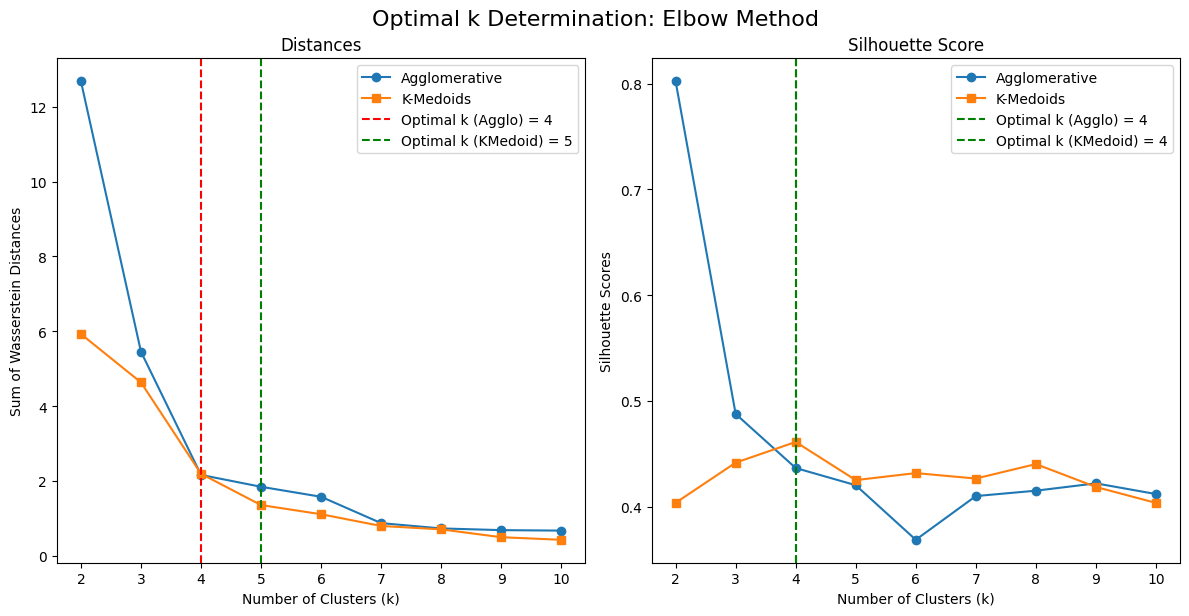

In [59]:
def plot_elbow_and_silhouette(k_values, results, manual_k=None):


    #kneelocator for finding elbow better than approximating with eye or visually
    kl_distance_agg = KneeLocator(
        k_values, results["agglomerative"]["cluster_distance"], curve="convex", direction="decreasing"
    ).elbow
    kl_distance_medoid = KneeLocator(
        k_values, results["kmedoids"]["cluster_distance"], curve="convex", direction="decreasing"
    ).elbow
    kl_silhouette_agg = manual_k_values["silhouette_agg"]
    kl_silhouette_medoid = manual_k_values["silhouette_medoid"]


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    #plot cluster distance sum (elbow method)
    axes[0].plot(k_values, results["agglomerative"]["cluster_distance"], marker='o', linestyle='-', label="Agglomerative")
    axes[0].plot(k_values, results["kmedoids"]["cluster_distance"], marker='s', linestyle='-', label="K-Medoids")
    axes[0].axvline(kl_distance_agg, color='red', linestyle='--', label=f"Optimal k (Agglo) = {kl_distance_agg}")
    axes[0].axvline(kl_distance_medoid, color='green', linestyle='--', label=f"Optimal k (KMedoid) = {kl_distance_medoid}")
    axes[0].set_title("Distances")
    axes[0].set_xlabel("Number of Clusters (k)")
    axes[0].set_ylabel("Sum of Wasserstein Distances")
    axes[0].legend()

    #plot silhouette scores (elbow method)
    axes[1].plot(k_values, results["agglomerative"]["silhouette"], marker='o', linestyle='-', label="Agglomerative")
    axes[1].plot(k_values, results["kmedoids"]["silhouette"], marker='s', linestyle='-', label="K-Medoids")
    axes[1].axvline(kl_silhouette_agg, color='green', linestyle='--', label=f"Optimal k (Agglo) = {kl_silhouette_agg}")
    axes[1].axvline(kl_silhouette_medoid, color='green', linestyle='--', label=f"Optimal k (KMedoid) = {kl_silhouette_medoid}")
    axes[1].set_title("Silhouette Score")
    axes[1].set_xlabel("Number of Clusters (k)")
    axes[1].set_ylabel("Silhouette Scores")
    axes[1].legend()

    plt.tight_layout()
    plt.suptitle("Optimal k Determination: Elbow Method", fontsize=16, y=1.02)
    plt.show()

#manual values if needed...
manual_k_values = {"distance_agg": 4, "distance_medoid": 5, "silhouette_agg": 4, "silhouette_medoid": 4}

plot_elbow_and_silhouette(k_values, results, manual_k=manual_k_values)



#### Silhouette Coefficient $ s^{(i)} $  
The **Silhouette Coefficient** is a key metric for evaluating the quality of clustering. It measures how well a point fits within its assigned cluster compared to how far it is from the nearest neighboring cluster. The score is calculated using two components: **cluster cohesion** and **cluster separation**.  

- **Cluster cohesion** ($ a^{(i)} $) is the average distance between a data point $ x^{(i)} $ and all other points within the same cluster.  
- **Cluster separation** ($ b^{(i)} $) is the average distance between $ x^{(i)} $ and all points in the nearest cluster.  

The Silhouette Coefficient $ s^{(i)} $ is then calculated as:  

$$
s^{(i)} = \frac{b^{(i)} - a^{(i)}}{\max\{b^{(i)}, a^{(i)}\}}
$$

The coefficient ranges between $-1$ and $1$, where a value close to $1$ indicates that a point is well-clustered, a value near $0$ suggests overlap between clusters, and negative values indicate potential misclassification.  

#### Elbow Plot for Optimal $ k $
The **Elbow Plot** is used to identify the optimal number of clusters ($ k $) by plotting the **sum of intra-cluster distances** or other metrics (e.g., Wasserstein distances) against different $ k $-values. The “elbow” point in the plot signifies the $ k $-value where adding more clusters results in diminishing returns in reducing intra-cluster distance.

#### Observations from the Plots  
The **Sum of Wasserstein Distances** (left plot) demonstrates a clear elbow at $ k = 4 $ for Agglomerative Clustering and $ k = 5 $ for K-Medoids, indicating a balance between compact clusters and reduced intra-cluster distances. The **Silhouette Score** (right plot) supports this observation, with $ k = 4 $ and $ k = 5 $ achieving the highest scores for Agglomerative Clustering and K-Medoids, respectively.  

#### Affects on Clustering Task  
The observed trends suggest that the chosen $ k $-values effectively balance cluster cohesion and separation while minimizing Wasserstein distances. The next step involves analyzing **Silhouette Coefficient Plots** to gain further insight into individual cluster quality and verify the appropriateness of the selected $ k $-values.  

In [49]:
def plot_silhouette_for_results(distance_matrix, results, k_values, method="agglomerative"):

    num_k = len(k_values)
    cols = min(num_k, 5)
    rows = math.ceil(num_k / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Flatten axes for easy indexing

    for idx, k in enumerate(k_values):
        ax = axes[idx]
        labels = results[method]["labels"][k]
        silhouette_vals = silhouette_samples(distance_matrix, labels, metric="precomputed")
        cluster_labels = np.unique(labels)
        n_clusters = cluster_labels.shape[0]
        y_ax_lower, y_ax_upper = 0, 0
        yticks = list()

        #loop through clusters and plot silhouette coefficients in end
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[labels == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i) / n_clusters)
            ax.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
            yticks.append((y_ax_lower + y_ax_upper) / 2.)
            y_ax_lower += len(c_silhouette_vals)

        #average silhouette score line
        silhouette_avg = np.mean(silhouette_vals)
        ax.axvline(silhouette_avg, color="red", linestyle="--")

        ax.set_title(f"Silhouette Plot for k={k}", fontsize=10)
        ax.set_xlabel("Silhouette Coefficient")
        ax.set_ylabel("Cluster")
        ax.set_yticks(yticks)
        ax.set_yticklabels(cluster_labels + 1)

    #remove unused subplots if any there
    for idx in range(len(k_values), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.suptitle(f"Silhouette Plots ({method.title()} Clustering)", fontsize=16, y=1.02)
    plt.show()



The next set of plots are important in reinforcing/understanding why the $ k $ values or number of clusters we chose before were optimal. We already saw the *lbow plots* earlier for sum of wasserstien distances confirm the optimal $ k $ values chosen, but these plots will further add confirmation and give more insight about the clusters.

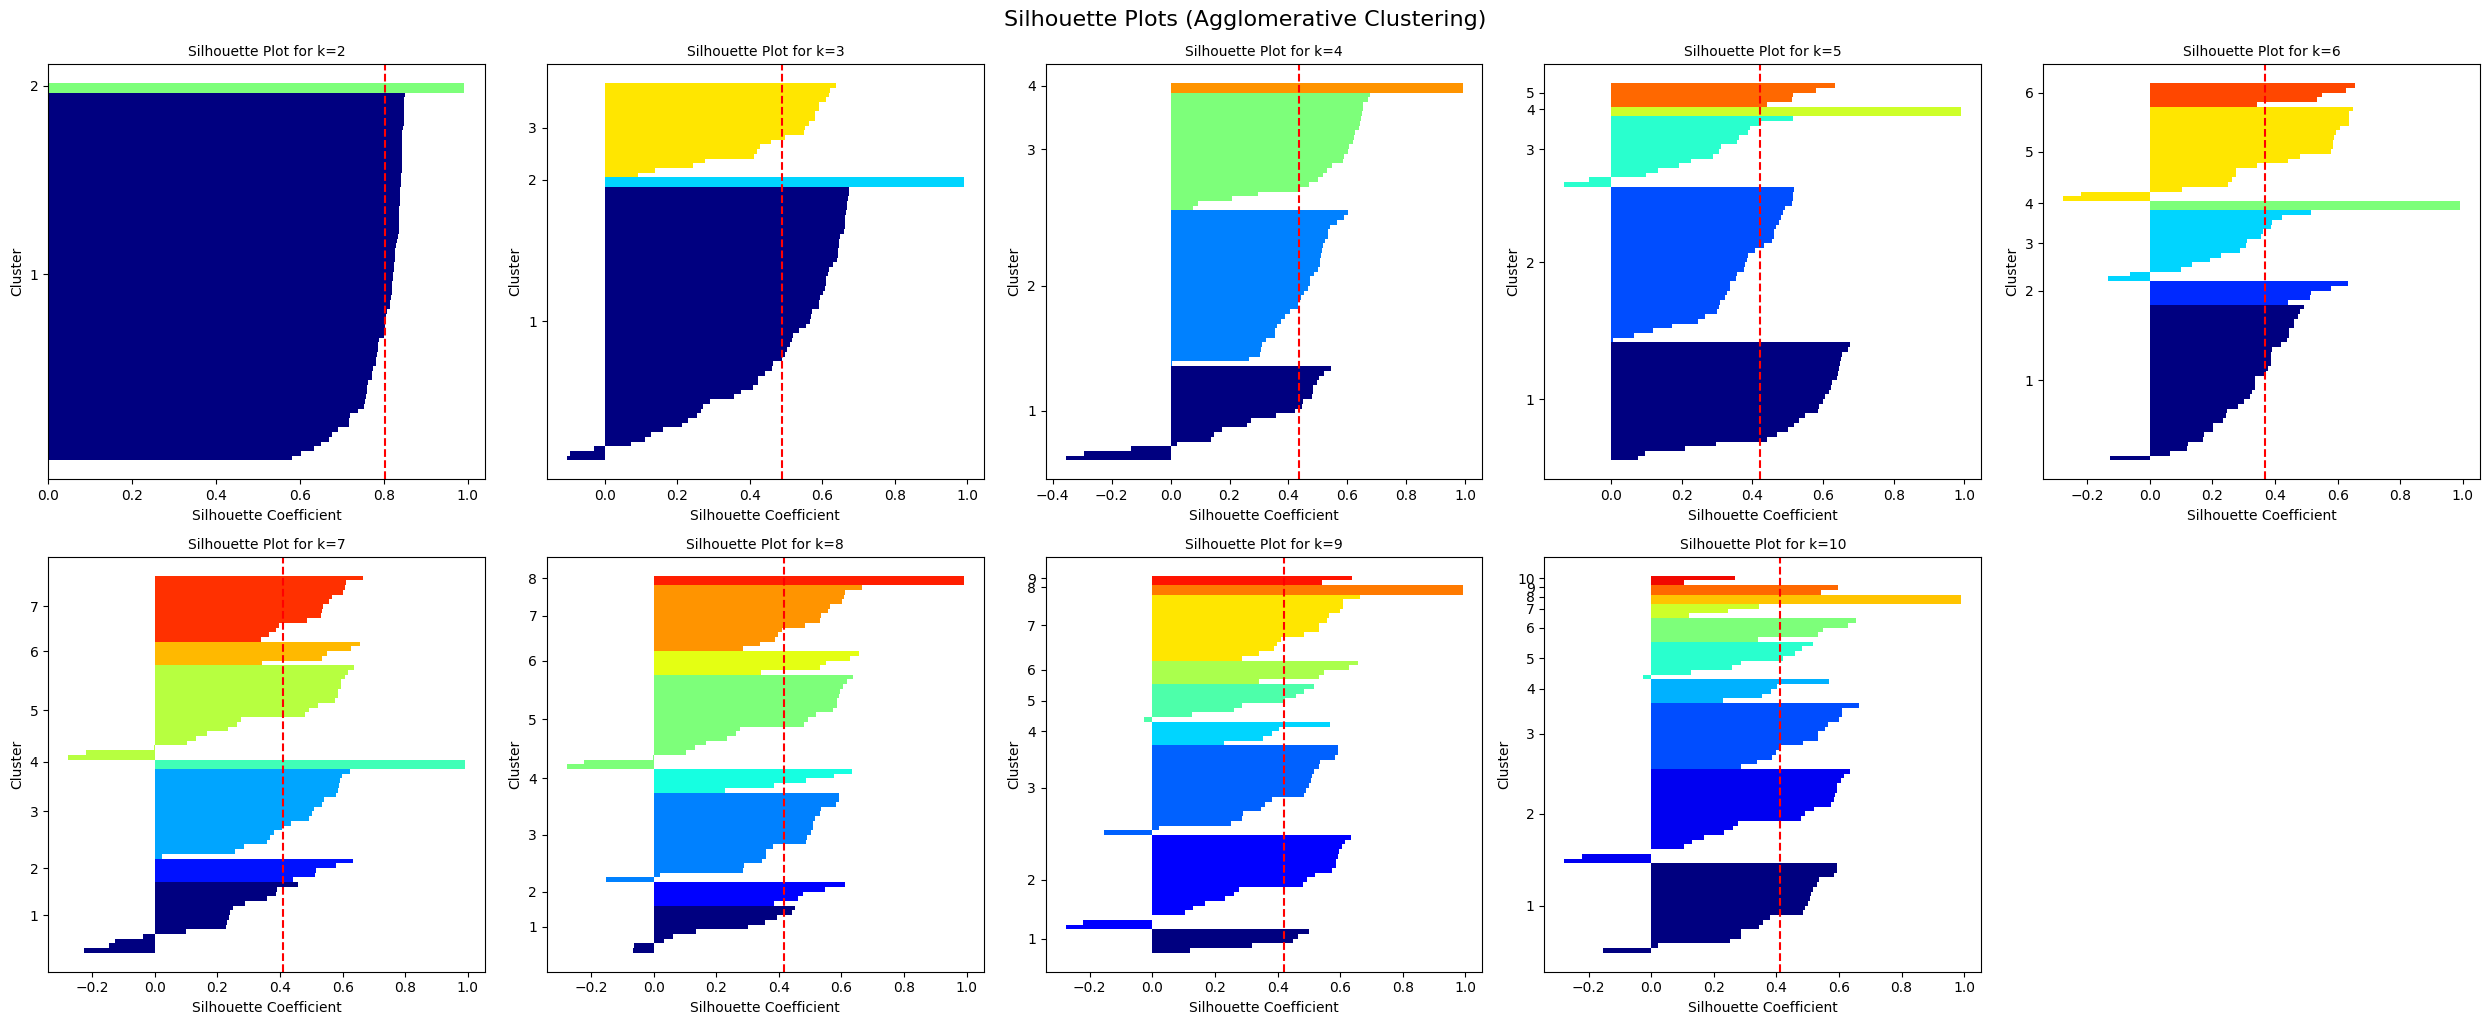

In [50]:
#silhouette coeff. plots for agglomerative clustering
plot_silhouette_for_results(distance_matrix, results, k_values, method="agglomerative")


#### Silhouette Plots and Their Significance  

Silhouette plots visually represent the silhouette coefficient for each point within a cluster, showing how well-separated the clusters are and how well the points fit into their assigned cluster. A **good silhouette plot** shows narrow, uniform bars with silhouette coefficients close to $1$, indicating that points are well-clustered and far from neighboring clusters:

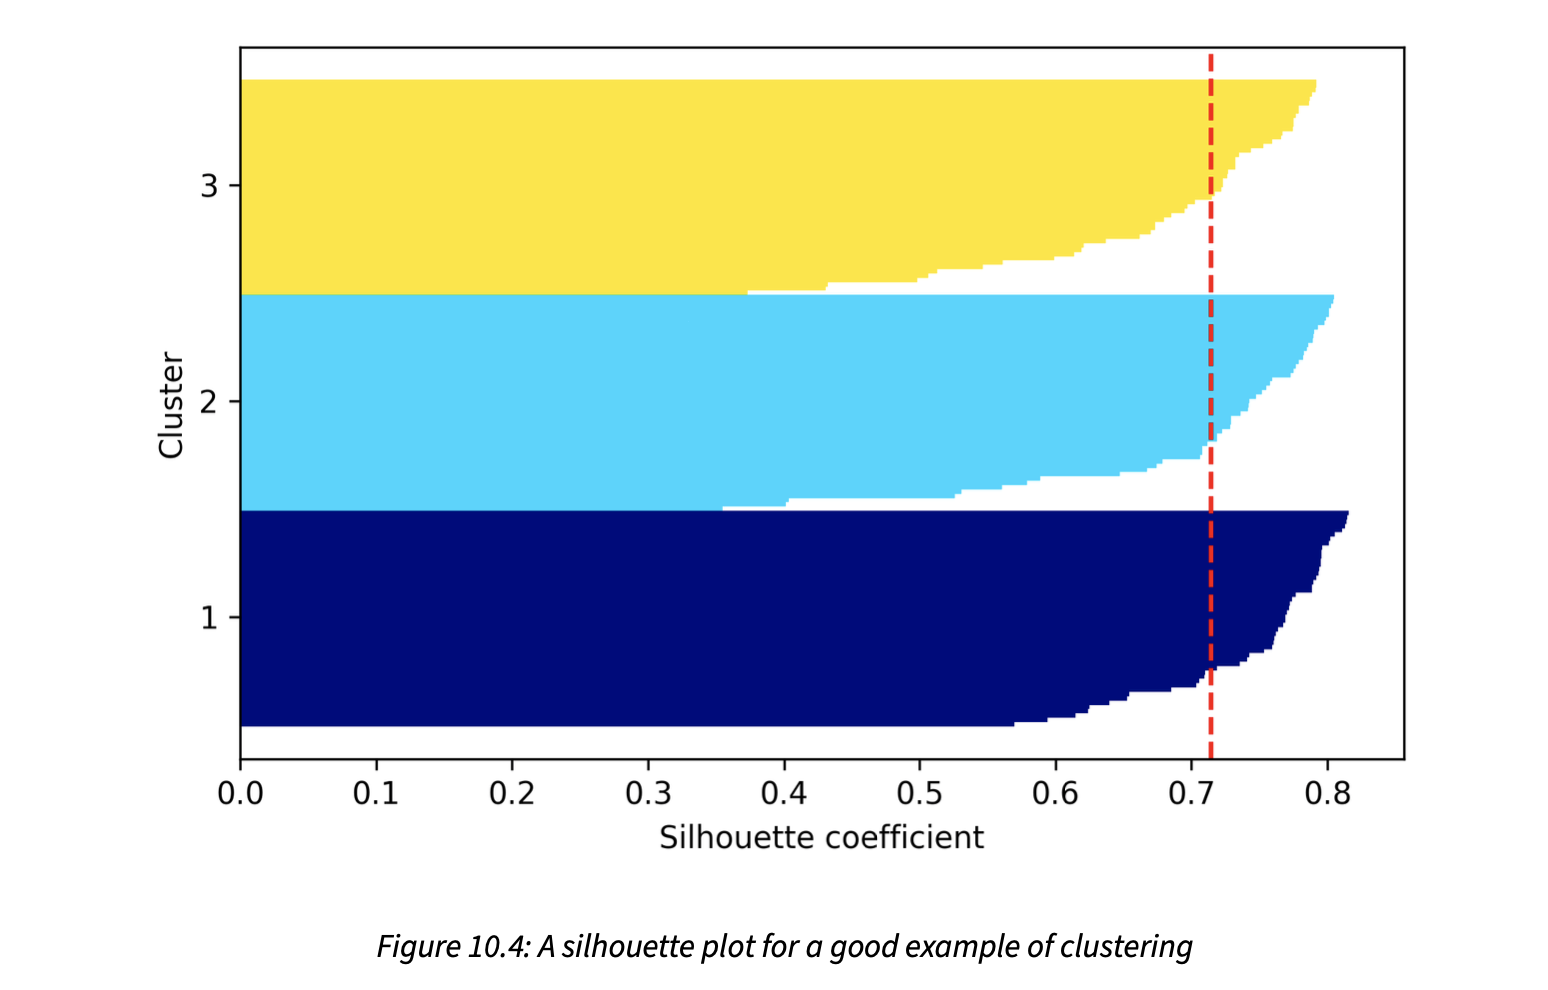

A **bad silhouette plot**, on the other hand, shows many negative or near-zero coefficients, indicating poor clustering assignments or overlapping clusters:

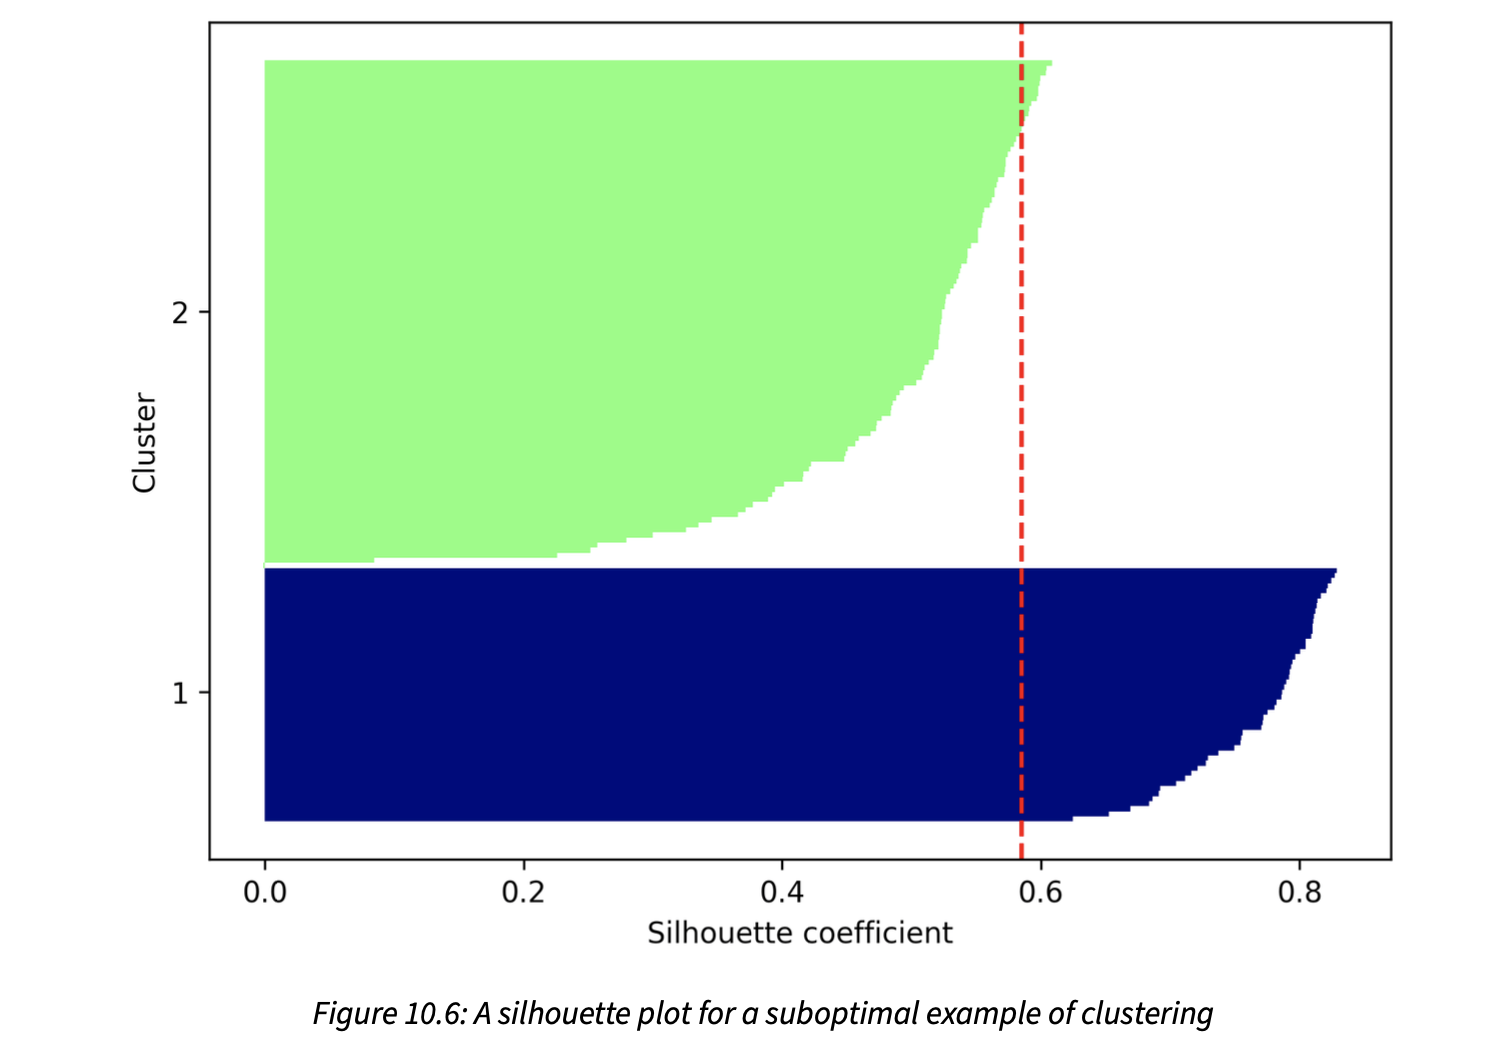

In clustering, a silhouette coefficient close to $1$ represents a well-clustered point, values close to $0$ suggest overlapping clusters, and negative values indicate misclassified points.

---

#### Observations from Silhouette Plots (Agglomerative Clustering)  

From the presented plots, it is evident that **k = 4** achieves the best balance of cluster structure in Agglomerative Hierarchical Clustering. While the silhouette plot for $ k = 4 $ does not exhibit perfect clustering (some clusters still show wide bars and small coefficients), it demonstrates a higher average silhouette score compared to other values of $ k $. This suggests that the four clusters are more cohesive and better-separated relative to other $ k $-values.

For lower $ k $-values, such as $ k = 2 $, the silhouette coefficients are artificially high due to fewer clusters, leading to oversimplified separation (**underfitting**). For higher $ k $-values (e.g., $ k = 7 $ to $ k = 10 $), the silhouette plots show increasing fragmentation of clusters, with wider and less uniform bars, indicating suboptimal cohesion (***overfitting**).

---

#### Impact on Clustering Task  
While $ k = 4 $ is not “perfect” based on the silhouette plot structure, it provides a reasonable clustering solution for the dataset. The clusters show moderate cohesion and separation, which aligns with the earlier Elbow Method results.


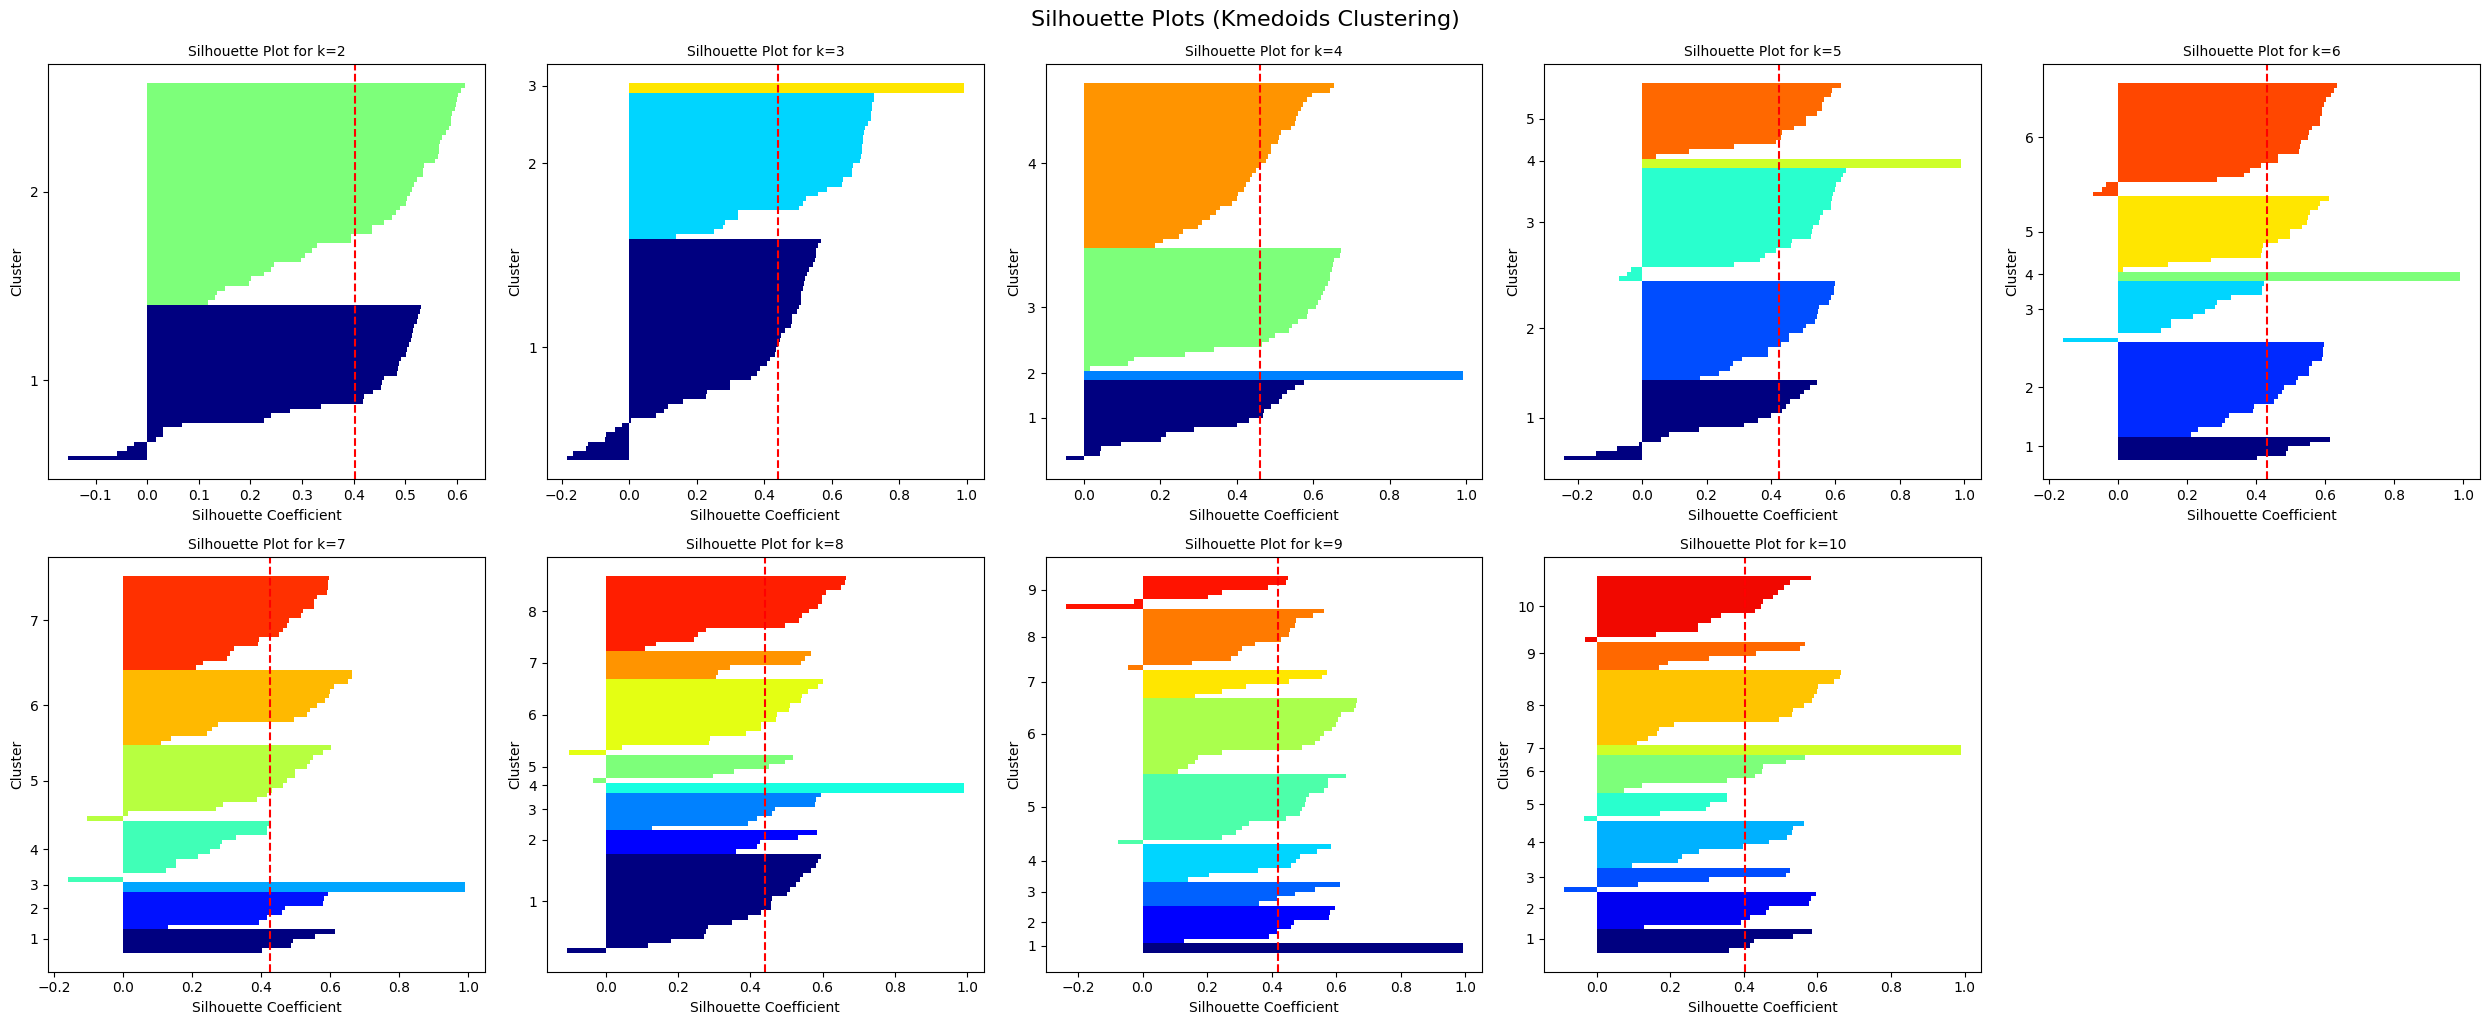

In [51]:
#silhouette coeff. plots for k-medoids

plot_silhouette_for_results(distance_matrix, results, k_values, method="kmedoids")

#### Observations from Silhouette Plots (K-Medoids Clustering)  

From the presented plots, **k = 5** emerges as the optimal value for K-Medoids clustering. The silhouette plot for $ k = 5 $ shows relatively well-formed clusters with moderate silhouette coefficients, indicating a balance between cluster cohesion and separation. The clusters show reasonable uniformity with fewer negative or near-zero silhouette coefficients compared to other $ k $-values. This suggests that the clustering structure at $ k = 5 $ achieves better intra-cluster compactness and inter-cluster separation.

For lower $ k $-values, such as $ k = 2 $ or $ k = 4 $, the silhouette plots indicate oversimplified clustering with high silhouette coefficients but poor separation of sub-clusters (**underfitting**). For higher $ k $-values (e.g., $ k = 6 $ to $ k = 10 $), the plots show increasing fragmentation (**overfitting**), where clusters have lower silhouette scores and a wider distribution of negative coefficients. This shows that excessive splitting at higher $ k $-values results in less cohesive clusters.



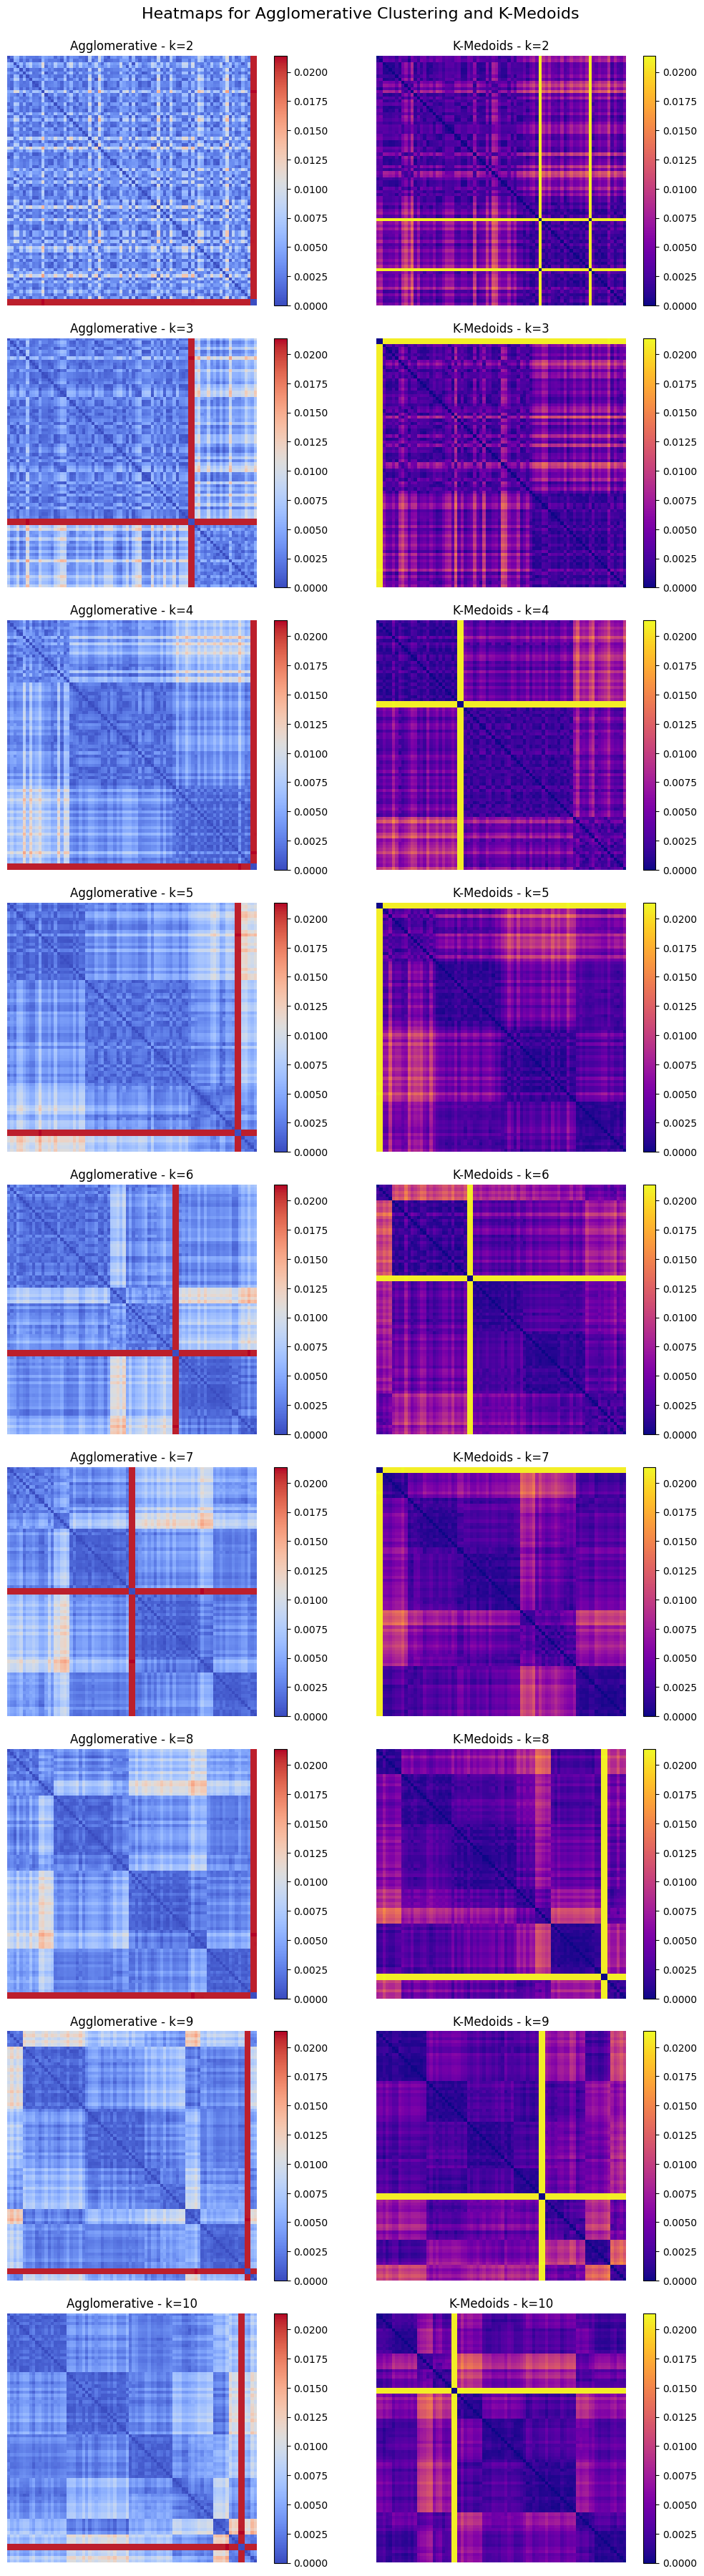

In [73]:
def plot_heatmaps_for_all_k(distance_matrix, results, k_values):

    n_rows = len(k_values)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
    plt.subplots_adjust(hspace=0.6, wspace=0.4)

    for idx, k in enumerate(k_values):

        #plot for agglomerative clustering
        ax_agg = axes[idx, 0]
        labels_agg = results["agglomerative"]["labels"][k]
        sorted_idx_agg = np.argsort(labels_agg)
        sorted_matrix_agg = distance_matrix[np.ix_(sorted_idx_agg, sorted_idx_agg)]

        cax_agg = ax_agg.imshow(sorted_matrix_agg, cmap="coolwarm", interpolation="nearest")
        ax_agg.set_title(f"Agglomerative - k={k}")
        ax_agg.axis("off")
        fig.colorbar(cax_agg, ax=ax_agg, fraction=0.046, pad=0.04)

        #plot for k-medoids
        ax_kmedoids = axes[idx, 1]
        labels_kmedoids = results["kmedoids"]["labels"][k]
        sorted_idx_kmedoids = np.argsort(labels_kmedoids)
        sorted_matrix_kmedoids = distance_matrix[np.ix_(sorted_idx_kmedoids, sorted_idx_kmedoids)]

        cax_kmedoids = ax_kmedoids.imshow(sorted_matrix_kmedoids, cmap="plasma", interpolation="nearest")
        ax_kmedoids.set_title(f"K-Medoids - k={k}")
        ax_kmedoids.axis("off")
        fig.colorbar(cax_kmedoids, ax=ax_kmedoids, fraction=0.046, pad=0.04)

    plt.suptitle("Heatmaps for Agglomerative Clustering and K-Medoids", fontsize=16, y = 0.999, x = 0.6)
    plt.tight_layout()
    plt.show()


#heatmap plots, there is a decent amount of magic numbers in this implementation, so faries each run (model instantiation & clustering run)
plot_heatmaps_for_all_k(distance_matrix, results, k_values=k_values)


The heatmaps presented above visualize the pairwise Wasserstein distance matrices for different values of $ k $ across Agglomerative Clustering and K-Medoids. Each heatmap is sorted by cluster labels to show the degree of cluster cohesion and separation. The darker blue blocks along the diagonal indicate lower intra-cluster distances, while lighter blue to red regions represent inter-cluster distances. The presence of clear, uniform diagonal blocks with minimal overlap suggests better clustering performance, as clusters are more cohesive internally and better separated from each other.

For Agglomerative Clustering, at lower k values such as $ k = 2 $ and $ k = 3 $, the clusters appear less distinct with significant overlap, as shown by less defined diagonal blocks. At $ k = 4 $, the heatmap reveals clearer and more uniform blocks along the diagonal, indicating a better-defined cluster structure. This suggests that $ k = 4 $ is the optimal value for Agglomerative Clustering, as increasing k further results in fragmented and less cohesive clusters. For higher $ k $ values, such as $ k = 8 $ to $ k = 10 $, the diagonal blocks become smaller and less uniform, showing excessive fragmentation and reduced cluster separation.

For K-Medoids, the heatmaps follow a similar trend, with $ k = 5 $ displaying the most distinct and well-separated clusters. At $ k = 5 $, the diagonal blocks are prominent, with minimal intra-cluster distances and clearer boundaries between clusters. Lower k values, such as $ k = 2 $ and $ k = 3 $, show larger diagonal blocks but with greater overlap between clusters. At higher $ k $ values, such as $ k = 8 $ to $ k = 10 $, the clusters become fragmented, reducing the clarity and separation of the diagonal blocks.

The observations from these heatmaps are consistent with previous results obtained from the silhouette coefficient and elbow method. For Agglomerative Clustering, $ k = 4 $ emerges as the optimal value, while for K-Medoids, $ k = 5 $ provides the best balance of cluster cohesion and separation. This consistency across multiple evaluation techniques reinforces the reliability of these $ k $ values.


### Comparative Analysis of the Two Methods on Each Dataset  

In this section, we will compare the clustering results of **Agglomerative Hierarchical Clustering** and **K-Medoids** algorithms. First, we will plot the images grouped into their respective clusters for each algorithm. This visualization will allow us to assess the clustering results and observe the distribution of images within each cluster.  

Next, we will generate **dendrograms** for the Agglomerative Hierarchical Clustering method. Dendrograms provide a hierarchical representation of the clustering process, showing how individual data points are merged into clusters at each level. This will help us evaluate the clustering hierarchy and identify relationships between the clusters.

We will then analyze **heatmaps of the pair-wise distance matrix** used by both clustering methods. The heatmaps will visualize the Wasserstein distances between data points for each $ k $-value. These heatmaps should reveal the internal cohesion of clusters and the separation between different clusters, offering further insight into the quality of the clustering.  

Finally, we will project the high-dimensional pair-wise distance matrix into a 2D space using **Multidimensional Scaling (MDS)**. This 2D visualization will provide a more intuitive understanding of the cluster structures and the relative positioning of images within and between clusters.  

This analysis will help evaluate the performance of the two clustering methods and determine a final recommendation on the method that should go into production for each dataset.





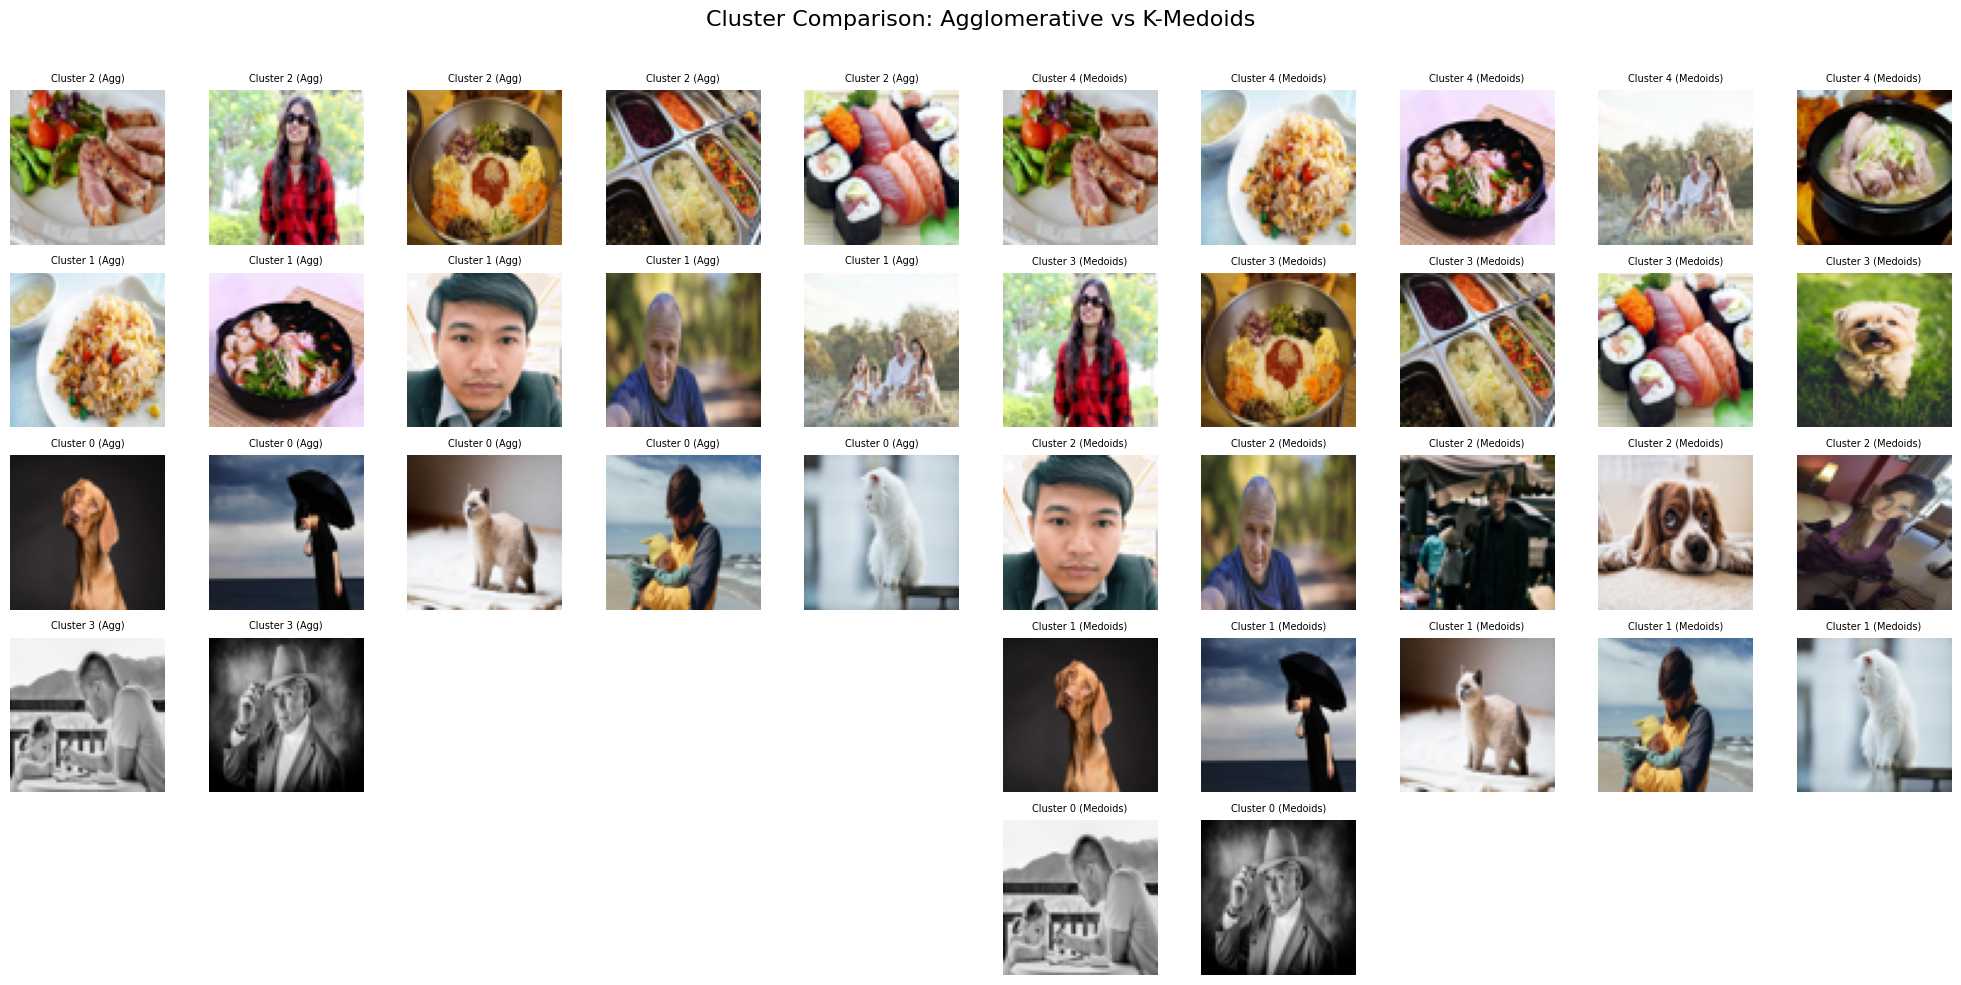

In [54]:

output_folder = "/content/drive/MyDrive/Term Project/Small Image Dataset for Unsupervised Clustering/photos_no_class_pre_processed"

#all image files from the output folder
path_images = [
    os.path.join(output_folder, file)
    for file in os.listdir(output_folder)
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
]


def display_images_side_by_side(path_images, labels_agg, labels_kmedoids, n_images=5, img_size=(64, 64)):

    groups_agg = dict()
    groups_kmedoids = dict()

    for file, cluster in zip(path_images, labels_agg):
        groups_agg.setdefault(cluster, []).append(file)

    for file, cluster in zip(path_images, labels_kmedoids):
        groups_kmedoids.setdefault(cluster, []).append(file)

    #find maximum rows needed
    n_clusters_agg = len(groups_agg)
    n_clusters_kmedoids = len(groups_kmedoids)
    n_rows = max(n_clusters_agg, n_clusters_kmedoids)
    n_cols = n_images * 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = np.array(axes).reshape(n_rows, n_cols)  #confirm 2D array of axes

    #loop through rows to display images
    for row in range(n_rows):

        #agglomerative clustering
        cluster_agg = list(groups_agg.keys())[row] if row < n_clusters_agg else None
        if cluster_agg is not None:
            images_agg = groups_agg[cluster_agg][:n_images]
            for col, img_path in enumerate(images_agg):
                ax = axes[row, col]
                img = Image.open(img_path).resize(img_size)
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(f"Cluster {cluster_agg} (Agg)", fontsize=7)
        else:
            #hide the unused agglomerative axes images
            for col in range(n_images):
                axes[row, col].axis("off")

        #k-medoids clustering
        cluster_kmedoids = list(groups_kmedoids.keys())[row] if row < n_clusters_kmedoids else None
        if cluster_kmedoids is not None:
            images_kmedoids = groups_kmedoids[cluster_kmedoids][:n_images]
            for col, img_path in enumerate(images_kmedoids):
                ax = axes[row, n_images + col]
                img = Image.open(img_path).resize(img_size)
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(f"Cluster {cluster_kmedoids} (Medoids)", fontsize=7)
        else:
            #hide the unused k-medoids axes images
            for col in range(n_images):
                axes[row, n_images + col].axis("off")


    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle("Cluster Comparison: Agglomerative vs K-Medoids", fontsize=16)
    plt.show()


display_images_side_by_side(path_images, labels_agg_main, labels_k_medoids_main, n_images=5, img_size=(64, 64))


The results of clustering using **Agglomerative Hierarchical Clustering** and **K-Medoids** show different patterns in how images were grouped. The use of **Opponent SIFT** features proved effective as it shows gradients and luminance variations, leading to the grouping of images that share similar illumination. This is particularly evident in what seemed to be black-and-white images (or images with low color variations), which are consistently grouped together, even though all images were processed in the RGB color space.  

In comparing the two methods, **K-Medoids** appears to produce better cluster assignments. Notably, the image of the **girl in a red flannel shirt**, which was assigned to "Cluster 2" in K-Medoids, aligns better with the other human-oriented images rather than being grouped alongside food images, as observed in Agglomerative Clustering. Additionally, **Cluster 4** in K-Medoids appears to contain a more coherent group of food-related images, suggesting a stronger separation between different categories like humans, animals, and food. However, this improvement may partially be coincidental and could warrant further investigation.  

Overall, **K-Medoids** in this visualization seems to demonstrate better clustering structure, with better groupings based on semantic features, while Agglomerative Clustering shows some overlap and inconsistencies in its cluster assignments. This indicates that the **PAM algorithm** used in K-Medoids, which minimizes intra-cluster dissimilarity, is better suited for the given dataset and feature representation.  


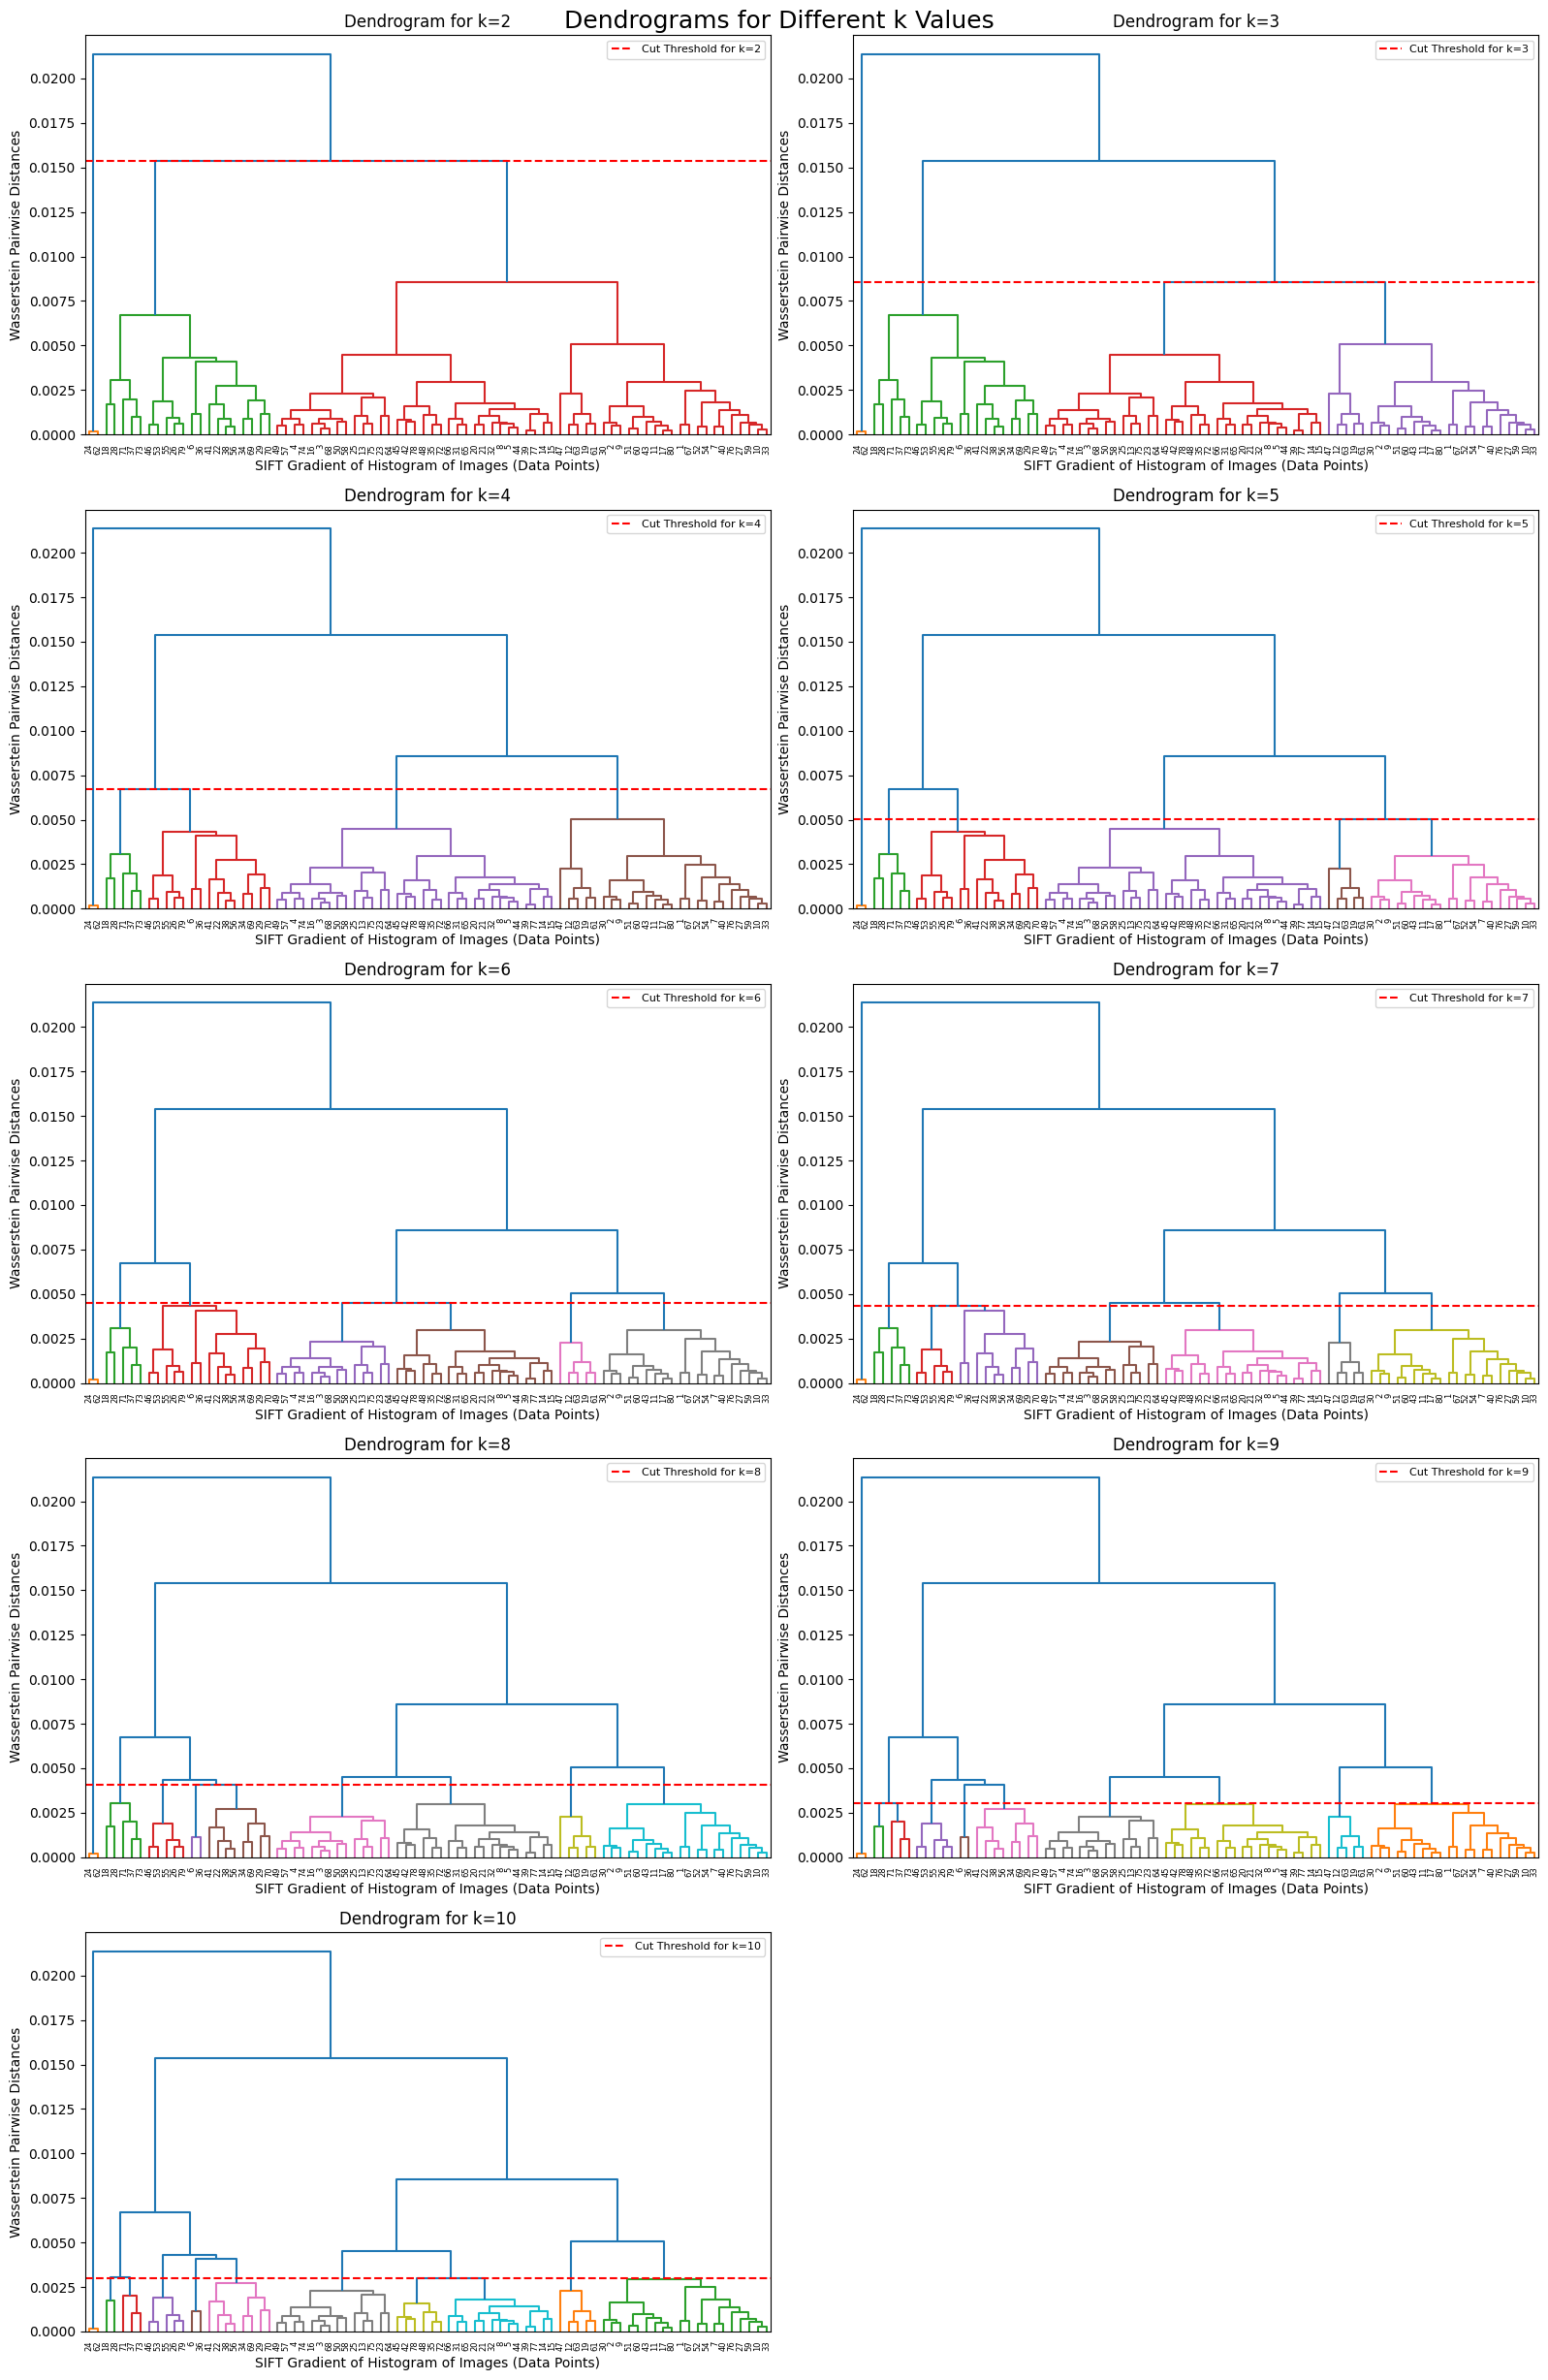

In [7]:
def plot_dendrograms_for_all_k(distance_matrix, k_values, linkage_method="complete"):

    #convert distance matrix to square form
    condensed_dist = squareform(distance_matrix)
    row_clusters = linkage(condensed_dist, method=linkage_method)

    n_rows = -(-len(k_values) // 2)
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))
    plt.subplots_adjust(hspace=0.7, wspace=0.4)
    axes = axes.flatten()

    for idx, k in enumerate(k_values):
        ax = axes[idx]

        #plot dendrogram
        dendrogram(row_clusters, ax=ax, labels=range(1, len(distance_matrix) + 1), color_threshold=row_clusters[-k, 2])

        ax.set_title(f"Dendrogram for k={k}", fontsize=12)
        ax.set_xlabel("SIFT Gradient of Histogram of Images (Data Points)", fontsize=10)
        ax.set_ylabel("Wasserstein Pairwise Distances", fontsize=10)

        #draw horizontal line to indicate cut threshold for k clusters
        threshold = row_clusters[-k, 2]
        ax.axhline(y=threshold, color="red", linestyle="--", label=f"Cut Threshold for k={k}")
        ax.legend(fontsize=8)

    for idx in range(len(k_values), len(axes)):
        fig.delaxes(axes[idx])

    #plotting
    plt.suptitle("Dendrograms for Different k Values", fontsize=18)
    plt.tight_layout()
    plt.show()

plot_dendrograms_for_all_k(distance_matrix, k_values=k_values, linkage_method="complete")


A **dendrogram** is a tree-like diagram used to represent the process of hierarchical clustering. It visually illustrates the merging or splitting of clusters at various distances, where the x-axis shows the data points, and the y-axis represents the pairwise distances between clusters (here, Wasserstein distances). By setting a horizontal cut threshold, we can determine the number of clusters $ k $ by observing where clusters are split at a given distance.

---

In these updated dendrograms, we observe the hierarchical clustering results for different $ k $-values ranging from 2 to 10. As the cut threshold increases (marked by the red dashed line), more clusters emerge. For smaller $ k $ values such as $ k = 2 $ and $ k = 3 $, the clusters are coarse, grouping large segments of data points together, which indicates lower granularity. At $ k = 4 $, the split appears more balanced with distinct, well-separated groups forming, suggesting this value aligns well with the dataset's structure. This observation is consistent with earlier silhouette score analysis and the elbow method, both of which indicated $ k = 4 $ as a meaningful balance between intra-cluster cohesion and separation.

As $ k $ increases to values such as $ k = 7 $ or higher, the dendrograms exhibit increasing fragmentation where clusters split at smaller Wasserstein distances. This behavior reflects over-segmentation, where clusters lose cohesiveness and become less meaningful. At $ k = 10 $, the granularity is particularly high, leading to overly fragmented clusters that may introduce redundancy or insignificant groupings.

These dendrograms reaffirm the agglomerative hierarchical clustering method's ability to capture the underlying structure of the dataset. The choice of $ k = 4 $ provides a balance between cluster granularity and separation. This result supports earlier findings from the silhouette score and elbow method analyses for optimal choice of k.


<ipython-input-74-24f5336405e5>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', np.unique(labels_agg).size)
<ipython-input-74-24f5336405e5>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_2 = cm.get_cmap('inferno', np.unique(labels_medoid).size)


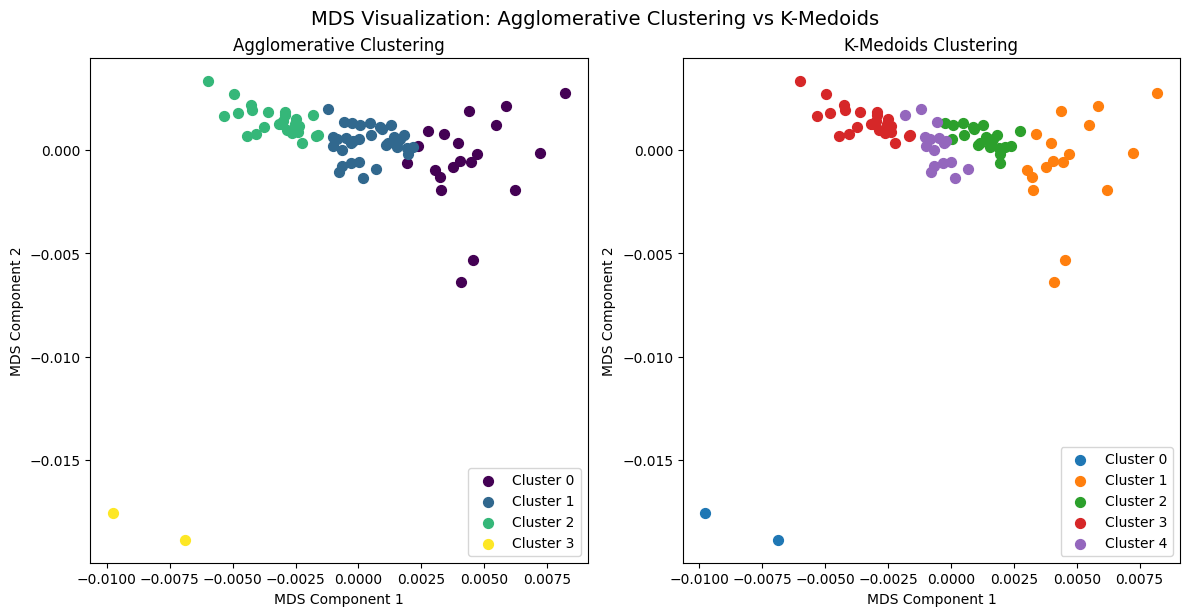

In [74]:

def plot_mds_with_clusters_combined(reduced_data, labels_agg, labels_medoid, titles):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    #ignore deprication warning if your on Matplotlib 3.7 >, it still works the code for cmap
    cmap = cm.get_cmap('viridis', np.unique(labels_agg).size)


    #plot agglomerative clustering
    ax = axes[0]
    for cluster_label in np.unique(labels_agg):
        ax.scatter(
            reduced_data[labels_agg == cluster_label, 0],
            reduced_data[labels_agg == cluster_label, 1],
            label=f"Cluster {cluster_label}",
            c=[cmap(cluster_label)],
            s=50
        )
    ax.set_title(titles[0], fontsize = 12)
    ax.set_xlabel("MDS Component 1")
    ax.set_ylabel("MDS Component 2")
    ax.legend()

    #plot k-medoids clustering
    ax = axes[1]
    for cluster_label in np.unique(labels_medoid):
        ax.scatter(
            reduced_data[labels_medoid == cluster_label, 0],
            reduced_data[labels_medoid == cluster_label, 1],
            label=f"Cluster {cluster_label}",
            s=50
        )
    ax.set_title(titles[1], fontsize = 12)
    ax.set_xlabel("MDS Component 1")
    ax.set_ylabel("MDS Component 2")
    ax.legend()

    plt.tight_layout()
    plt.suptitle("MDS Visualization: Agglomerative Clustering vs K-Medoids", fontsize=14, y=1.02)
    plt.show()

#MDS manifold for plotting into 2D to view datapoints on cluster. random_state is for reproducability only. Isn't necessay.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
reduced_data = mds.fit_transform(distance_matrix)

plot_mds_with_clusters_combined(reduced_data, labels_agg_main, labels_k_medoids_main, ["Agglomerative Clustering", "K-Medoids Clustering"])


**Multidimensional Scaling (MDS)** is a dimensionality reduction technique that projects data into a lower-dimensional space while preserving the pairwise distances between data points as accurately as possible. Mathematically, MDS minimizes the stress function.

MDS is useful in this case because it directly operates on the precomputed pairwise distance matrix, such as the **Wasserstein distances** used here. Unlike techniques like PCA, t-SNE, or Isomap, which require access to the original features or focus on non-linear embeddings, MDS works purely with the dissimilarity matrix. This makes it ideal for visualizing clustering results when distances are already computed, such as from histograms of Opponent SIFT gradients.

---

From the **MDS visualization** above, we observe the clustering results of both Agglomerative Clustering (left) and K-Medoids (right). The MDS plot shows that the clusters are not linearly separable, as there is significant overlap between clusters in both methods. This suggests that the underlying structure of the data may exhibit non-linearity, which could limit the performance of these clustering algorithms.  

For **Agglomerative Clustering**, the clusters are less distinct, with noticeable overlap among data points, particularly in the center. This indicates challenges in achieving clean separation, potentially due to the hierarchical nature of the algorithm and the lack of distinct boundaries between clusters.

In contrast, **K-Medoids Clustering** appears to form slightly better-separated clusters. With 5 clusters, the groupings are more defined, and the additional cluster allows for better differentiation of data points. This aligns with earlier findings, where $ k = 5 $ emerged as the optimal value for K-Medoids. However, the overlap still shows challenges with the dataset's structure.

While MDS effectively visualizes the pairwise distances, the lack of clear separation shows limitations in the linearity of the clusters. This could imply that further improvements might require non-linear clustering techniques or adjustments to the features. Nonetheless, K-Medoids demonstrates superior performance relative to Agglomerative Clustering, as seen in the improved cluster groupings in this visualization.


####Final Reccomendation

Based on the results from the two clustering models, **K-Medoids appears to cluster better than Agglomerative Hierarchical Clustering**. The higher number of clusters ($k = 5$) in K-Medoids leads to a more intuitive grouping of the dataset, as seen in our previous visualizations. This suggests that K-Medoids adapts better to the dataset's structure compared to Agglomerative Clustering at $k = 4$.

While K-Medoids is the preferred method from this analysis, there is evidence that further improvements can be made. Observations from the MDS visualization showed that the cluster points are closely packed together with little spacing between them. This indicates that the dataset may not align well with average cluster structures typically produced by K-Medoids or Agglomerative Clustering, which assume spherical or linearly separable clusters.

The irregular and potentially non-linear shape of the clusters suggests that density-based methods such as **DBSCAN or OPTICS** could perform better. These algorithms do not require specifying the number of clusters $k$ and instead rely on parameters such as epsilon (*eps*) and *minimum samples* for DBSCAN, or *xi* for OPTICS. These methods could adapt to the dataset's irregular shape, finding clusters based on density rather than distance alone.

Future work should explore DBSCAN or OPTICS to address the non-linear cluster boundaries observed in this dataset. Another feasible option might be fuzzy approaches with a soft clustering vs hard clustering as they allow points to belong to multiple clusters with varying degrees of membership, which could better handle the irregular and overlapping cluster boundaries observed in the dataset. These methods could prove to be better clustering solutions.

---

*Note:* Interestingly, the optimal $k$ value we find for K-Medoids happens to be the number of labels for each of the images from the file names. In the kaggle site for the dataset they mention:

`"This small dataset includes 80 photos of dogs (10), cats (10), family (20), alone (20), and food (20). There is no labeling info, but you will see it clearly."`

so K-Medoids might be more accurate as per this description from the kaggle, as it successfully finds optimal number of clusters being 5 to match 5 labels. Of course since this is an unsupervised task, we approached this dataset with ignoring the filename labels and hence our explanation above doesn't include this fact about the true number of class label.

### Discussion on Ethical Issues for this Dataset

The small size of this dataset, consisting of only 80 images introduces a fair amount of ethical concerns. The dataset includes pictures of people, their pets, food items, and other personal scenes, which raises questions about **Privacy Preservations**. The means by which this data was collected are unclear, and such content can be sensitive. Notably, the description on the Kaggle site itself poses the question: `"Is it possible to cluster all the photos in your phone automatically without labeling?"` This suggests a scenario where personal data from users' devices could be used to test or train models, potentially without explicit user agreement. Utilizing personal photos in this manner without consent risks breaching privacy and raises concerns about ethical data handling.

The limited number of samples further exacerbates ethical issues. A small dataset can amplify **data biases**, as it may not adequately capture diversity across the categories. Clustering models may group images based on superficial or dominant features influenced by the restricted data rather than genuinely meaningful patterns. This can result in faulty or biased representations, particularly when images are grouped incorrectly due to the absence of ground truth labels.

In the context of *unsupervised learning*, an additional challenge arises due to the lack of concrete class labels. Without these labels, evaluating the correctness of clusters becomes subjective. Although visual inspection of clusters can help determine if groupings seem reasonable, this assessment is not definitive. This introduces **algorithmic fairness** concerns, as certain patterns or groups may be overrepresented, reinforcing unintended biases.

**Transparency and explainability** are also an issue in this context. Clustering decisions are made using high-dimensional features, such as the Opponent SIFT histograms we utilized, which may lack interpretability. This  prevents users from understanding why certain images are grouped together the way they are, limiting trust in the model's decisions.


###Bibliography

1. **Book Reference**  
   *Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python*  
   **Authors**: Sebastian Raschka, Yuxi (Hayden) Liu, Vahid Mirjalili  

2. **Unsupervised Clustering Methods**  
   [Kaggle Notebook: Clustering - KMeans, KMedoids, HC, Fuzzy, DBSCAN, OPTICS](https://www.kaggle.com/code/sylwiakmiec/clustering-kmeans-kmedoids-hc-fuzzy-dbscan-optics#E)-Agglomerative-Hierarchical-Clustering)

3. **OPTICS Clustering**  
   [Scikit-Learn Documentation: OPTICS](https://scikit-learn.org/dev/modules/generated/sklearn.cluster.OPTICS.html)

4. **Agglomerative Clustering**  
   [Scikit-Learn Documentation: Agglomerative Clustering](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

5. **MDS (Multidimensional Scaling)**  
   [Scikit-Learn Documentation: MDS](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.MDS.html)

6. **Silhouette Coefficient**  
   [Scikit-Learn Documentation: Silhouette Samples](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html)  
   [Scikit-Learn Documentation: Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

7. **K-Medoids Clustering**  
   [Scikit-Learn-Extra Documentation: KMedoids](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html)

8. **Knee Detection for Elbow Method**  
   [Kneed Documentation](https://kneed.readthedocs.io/en/stable/parameters.html)

9. **SIFT Feature Extraction**  
   [OpenCV Tutorial: Introduction to SIFT](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

10. **K-Medoids Explanation**  
    [GeeksforGeeks: ML - K-Medoids Clustering with Example](https://www.geeksforgeeks.org/ml-k-medoids-clustering-with-example/)
